**Supplemental Material for the paper**

# Fabry-Pérot resonant vortices and magnetoconductance in topological insulator constrictions with magnetic barriers 

R.P.Maciel$^{1}$, A.L. Araújo$^{1}$, C.H. Lewenkopf$^{2}$, and G.J.Ferreira$^{1}$

$^{1}$ *Instituto de Física, Universidade Federal de Uberlândia, MG 38400-902, Brazil*

$^{2}$ *Instituto de Física, Universidade Federal Fluminense, 24210-346 Niteroi, RJ, Brazil*

In [1]:
# importing all libraries to be used in this code

# plot and general purposes
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import find_peaks
from scipy import integrate

# to use qsymm
import qsymm
import sympy as sp
sp.init_printing(print_builtin=True)

# to use kwant
import kwant
import kwant.continuum as kc
import tinyarray as ty

# avoid warnings reguarding the sympy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 2D TI constriction and Fabry-Perot resonances

Here we consider a generic TI given the BHZ model (with $C=D=0$ for simplicity)

$H(k_{x}, k_{y})=\begin{pmatrix}h(\mathbf{k}) & 0 \\ 0 & h^{*}(\mathbf{-k})\end{pmatrix}$

$h(\mathbf{k}) = [Ak_{y}\sigma_y-Bk_{y}^2\sigma_z] + [Ak_{x}\sigma_x-Bk_{x}^2\sigma_{z}] + M\sigma_z$

Here the $\sigma$ matrices act on the E1/H1 orbital space, while the spin space is explicit in the block-matrix form of H.

## Dimensionless form

Using the bulk gap $|M|$ as the unit of energy and $A/|M|$ as the unit of distance, $h(\mathbf{k})$ simplifies to the dimensionless form

$h(\mathbf{k}) = [k_{y}\sigma_y-\beta k_{y}^2\sigma_z] + [k_{x}\sigma_x-\beta k_{x}^2\sigma_{z}] + \mu \sigma_z$

where

$\mu = \frac{M}{|M|} = \pm 1$ defines the gap sign for the trivial and topological regimes.

$\beta = \frac{|M|}{A^2} B$ is the Wilson's mass. For typical HgTe/CdTe parameters, $\beta \approx -0.1$. The exact value of $\beta$ is not imporant for the results, what matters is that $|\beta| \ll 1$, such that the linear terms dominate the dispersion relation at low energies.

## Fermion doubling problem

Within this dimensionless form, to avoid the Fermion doubling problem we want the Wilson's mass value to satisfy

$\dfrac{\delta_x^2 \delta_E}{2} < |\beta| < \dfrac{1}{\delta_E}$, where $\delta_x$ is the discretization step and $\delta_E$ is the relevant energy window.

A reasonable choice is $\delta_E = 1$, which sets the upper limit $|\beta| < 1$, while the lower limit constrains the discretization step $\delta_x^2 < 2 |\beta|$. For $|\beta| = 0.1$, we have $\delta_x < 0.45$. But ideally, $\delta_x \ll 0.45$.

## Implementation

The function below implements the 2D model with the constriction following the expressions above.

In [2]:
# pauli matrices
s0 = ty.array([[1,0], [0,1]]);
sx = ty.array([[0,1], [1,0]]);
sy = ty.array([[0,-1j],[1j, 0]]);
sz = ty.array([[1,0],[0,-1]]);

def makesys(beta=-0.1, mu=-1, dx=0.2, Lc=15, Wc=3, Lx=20, Wl=6):
    '''
    Builds the system, leads, and auxiliary model to obtain the bands at the constriction.
    
    INPUT:
      beta and mu: BHZ parameters as described above.
      dx: discretization step
      Lc, Wc: lenght and width of the constriction
      Lx: lenght of the full system, Lx > Lc
      Wl: width of the leads, Wl > Wc
    
    OUTPUT:
      syst: full system with the constriction geometry and leads
      cons: auxiliary model containing only the constriction to get its bands
      bars: function defining the barriers potentials adapted for the system geometry
    '''
        
    # function for the barriers
    def bars(x, y, Nb, Wb, PAP):
        # if no bars
        if Nb == 0:
            return 0
        # else
        # barrier positions equally spaced accross the constriction
        bpos = np.array([(n+1)*Lc/(Nb+1) for n in range(Nb)])
        bpos += -0.5*Lc # shift from start
        # barrier sign: 
        #    PAP=+1 all barriers with the same sign
        #    PAP=-1 sign alternate from one barrier to the other
        bsign = np.array([PAP**n for n in range(Nb)])
        # check if x in bars
        for n in range(Nb):
            if np.abs(x-bpos[n]) < Wb/2:
                return bsign[n]
        # else
        return 0
    # end bars
    
    # models in continuum form
    # leads = pure 2D TI
    Hleads = 'k_x*kron(sigma_z,sigma_x) + k_y*kron(sigma_0,sigma_y) + (mu-beta*(k_x**2+k_y**2))*kron(sigma_0,sigma_z)'
    # constriction = 2D TI + barriers
    Hconst = Hleads + ' + bars(x, y, Nb, Wb, PAP)*(kron(vs*sigma_0 + vx*sigma_x + vz*sigma_z, sigma_0))'
    
    # parameters
    subs = {'beta':beta, 'mu':mu}
    # templates
    Tconst = kc.discretize(Hconst, grid=dx, locals=subs)
    Tleads = kc.discretize(Hleads, grid=dx, locals=subs)
    
    # shapes
    def constriction_shape(site):
        (x, y) = site.pos
        return (np.abs(x) < Lc/2 and np.abs(y) < Wc/2) or ((Lc/2 <= np.abs(x) < Lx/2) and np.abs(y) < Wl/2)
    # end constriction
    def leads_shape(site):
        (x, y) = site.pos
        return (np.abs(y) < Wl/2)
    # end leads
    def infconst_shape(site):
        (x, y) = site.pos
        return (np.abs(y) < Wc/2)
    # end infconst

    # build system and leads
    syst = kwant.Builder()
    syst.fill(Tconst, constriction_shape, (0, 0))
    lead = kwant.Builder(kwant.TranslationalSymmetry([-dx, 0]), conservation_law=np.kron(sz, s0))
    lead.fill(Tleads, leads_shape, (0, 0))
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()
    # build auxiliary constriction for its bands
    cons = kwant.Builder(kwant.TranslationalSymmetry([-dx, 0]))
    cons.fill(Tleads, infconst_shape, (0, 0))
    cons = cons.finalized()
    
    return syst, cons, bars

# 1D effective model for the edge states

We build an effective 1D model for the edge states with two purposes:

- simplify the calculations to allow us to vary parameters more efficiently and analyze the results
- to obtain analytical expressions for the transmission in particular and relevant cases

At $k_x=0$, for each spin $\sigma$, if edge states from opposite sides (**T**op and **B**ottom) overlap due to the small $W_c$ of the constriction, they open an hybridization gap $2|\Delta|$ with eigenstates given by their symmetric and anti-symmetric combinations, thus the base becomes

$|S,\sigma\rangle = |T,\sigma\rangle + |B,\sigma\rangle$

$|A,\sigma\rangle = |T,\sigma\rangle - |B,\sigma\rangle$

Here we consider that the system is invariant under the mirror $M_y$, inversion $I$ and time-reversal symmetries. Notice that in the BHZ model for HgTe/CdTe the system is only approximately inversion symmetric. We follow the same approximation here. The matrix representations for these operations are cast in the QSYMM code below with the basis ordered as

$|S,\uparrow\rangle$, $|A,\uparrow\rangle$, $|S,\downarrow\rangle$, $|A,\downarrow\rangle$

Up to linear order in k_x:


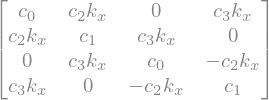

and the second order terms:


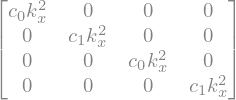

In [3]:
# symmetry operations in Hilbert space: spin x orbital

# symmetry operation: Mirror y -> -y and T <> B
# ----------------------------------
# Hilbert space representation
pU = np.kron(1j*sy, sz)
# (x) representation
pR = sp.Matrix([[1]])
# full symmetry element
My = qsymm.PointGroupElement(pR, False, False, pU)

# symmetry operation TRS
# ----------------------
# Hilbert space representation
pU = np.kron(1j*sy, s0)
# (x) representation
pR = sp.Matrix([[1]])
# full symmetry element
TRS = qsymm.PointGroupElement(pR, True, False, pU)

# symmetry operation Inversion
# ----------------------
# Hilbert space representation
pU = np.kron(s0, sz)
# (x) representation
pR = sp.Matrix([[-1]])
# full symmetry element
Inv = qsymm.PointGroupElement(pR, False, False, pU)

# consider
symmetries = [My, TRS, Inv]

# find and print model
print("Up to linear order in k_x:")
Hk01 = qsymm.continuum_hamiltonian(symmetries, dim=1, total_power=[0,1], prettify=True)
qsymm.display_family(Hk01, summed=True)

print("and the second order terms:")
Hk2 = qsymm.continuum_hamiltonian(symmetries, dim=1, total_power=[2], prettify=True)
qsymm.display_family(Hk2, summed=True)

Considering the first matrix above (up to linear order), we can choose $c_0 = +m$, $c_1 = -m$ for simplicity and to keep the spectrum particle-hole symmetric. The Fermi velocity we write as $c_2 = \alpha$. The $c_3$ term is an spin-orbit coupling between opposite spin edge states, which we assume to be small, thus $c_3 = 0$ (notice that $c_3$ would lead to k² corrections to the eigenvalues, we can neglect it). On the second order terms, we similarly choose $c_0 = -c_1 = \gamma$. Thus, we get the model

$H_{1D} = (m - \gamma k_x^2) (s_0 \otimes \tau_z) + \alpha (s_z \otimes \tau_x) k_x$

Here the $s$ matrices act on spin, and the $\tau$ matrices on the orbitals S/A.

# Constriction vs leads

**The gap term m:** At the constriction, $m \rightarrow m_c = \Delta$ defines the hybridization gap. On the other hand, at the leads the edges are far appart, and $m \rightarrow m_l = 0$.

**The velocity term $\alpha$:** At the leads, $\alpha \rightarrow \alpha_l = A = 1$ (in our dimensionless units), while at the constriction some deviation could be exectead $\alpha \rightarrow \alpha_c \neq \alpha_l$, but for simplicity we keep $\alpha_c = \alpha_l = 1$.

**The Wilson's mass term $\gamma$:** For the analytical solution we use $\gamma=0$ for simplicity, while for the numerics we keep $\gamma_l = \gamma_c = -0.1$ to avoid the Fermion doubling problem.

## Analytical transmission

Using this 1D model and a stardard S-matrix approach we find

$T_{\sigma,\sigma}(\varepsilon) = \dfrac{2(\varepsilon^2 - \Delta^2)}{2\varepsilon^2-\Delta^2[1+\cos(\theta)]}$, with $\theta = (2L_c/\alpha)\sqrt{\varepsilon^2-\Delta^2}$

The transmission peaks $T=1$ are Fabry-Perot resonances and occur at

$\varepsilon^\pm_n = \pm \sqrt{\left(\dfrac{\alpha}{L_c} n\pi\right)^2 + \Delta^2}$

with a Gaussian broadening of

$\gamma_n \approx \dfrac{1}{\sqrt{2}} \Big(\dfrac{\alpha}{L_c}\Big)^3 \Big( \dfrac{n \pi}{\Delta}\Big)^2$

Notice that both scale with $\alpha/L_c$. Therefore, to get well defined peaks our only tunning parameter is the hybridization gap $\Delta$.

## Adding the barriers

If we consider the barriers, the analytical solution for the 1D model becomes huge and difficult to handle. It is more efficient to consider the numerical implementation below.

As discussed above, here we assume $\alpha_c = \alpha_l = 1$, $m_l = 0$, $m_c = \Delta$, and $\gamma_c = \gamma_l = -0.1$.

In [4]:
def make1Dmodel(delta=0.1, gamma=-0.1, dx=0.2, Lc=15):
        
    # function for the barriers
    def bars(x, Nb, Wb, PAP):
        # if no bars
        if Nb == 0:
            return 0
        # else
        # barrier positions
        bpos = np.array([n*Lc/(Nb+1) for n in range(1,Nb+1)])
        bpos += -0.5*Lc # shift from start
        # barrier sign
        bsign = np.array([PAP**n for n in range(0,Nb)])
        # check if x in bars
        for n in range(1,Nb+1):
            if np.abs(x-bpos[n-1]) < Wb/2:
                return bsign[n-1]
        # else
        return 0
    # end bars
    
    # models in continuum form
    Hconst = 'k_x*kron(sigma_z,sigma_x) + (delta - gamma*(k_x**2))*kron(sigma_0,sigma_z) + bars(x, Nb, Wb, PAP)*(kron(vs*sigma_0 + vx*sigma_x + vz*sigma_z, sigma_0))'
    Hleads = 'k_x*kron(sigma_z,sigma_x) + (      - gamma*(k_x**2))*kron(sigma_0,sigma_z) '
    # parameters
    subs = {'gamma':gamma, 'delta':delta}
    # templates
    Tconst = kc.discretize(Hconst, grid=dx, locals=subs)
    Tleads = kc.discretize(Hleads, grid=dx, locals=subs)
    
    # shapes
    def constriction_shape(site):
        (x,) = site.pos
        return (np.abs(x) < Lc/2)
    def leads_shape(site):
        (x,) = site.pos
        return (True)
    # end constriction

    # build system and leads
    syst = kwant.Builder()
    syst.fill(Tconst, constriction_shape, (0,))
    lead = kwant.Builder(kwant.TranslationalSymmetry([-dx,]), conservation_law=np.kron(sz, s0))
    lead.fill(Tleads, leads_shape, (0,))
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()
    
    return syst, bars

# Transmission

For the 1D model without barriers we use the analytical expression above.

For the 1D model with barriers or for the 2D model, we use the numerical methods from kwant to calculate the transmission.

Both are implemented below.

In [5]:
def Tmodel1D(ek, alpha, Lc, Delta):
    theta = (2*Lc/alpha)*np.sqrt(0j+ ek**2 - Delta**2)
    T = 2*(ek**2 - Delta**2)/(2*ek**2 - Delta**2*(1+np.cos(theta)))
    return T.real

def transmission(syst, erange, params, reflections=False, polarizations=False):
    Guu = []
    Gud = []
    Gdu = []
    Gdd = []
    Ruu = []
    Rud = []
    Rdu = []
    Rdd = []
    P0 = []
    Px = []
    Py = []
    Pz = []
    for en in tqdm(erange):
        # indexes: output - input
        
        smatrix = kwant.smatrix(syst, en, params=params)
        # transmissions: first index=lead, second index =block down(0) or up(1)
        Gdd.append(smatrix.transmission((0, 0), (1, 0)))
        Gdu.append(smatrix.transmission((0, 0), (1, 1)))
        Gud.append(smatrix.transmission((0, 1), (1, 0)))
        Guu.append(smatrix.transmission((0, 1), (1, 1)))
        # reflections
        Ruu.append(smatrix.transmission((0, 0), (0, 0)))
        Rud.append(smatrix.transmission((0, 0), (0, 1)))
        Rdu.append(smatrix.transmission((0, 1), (0, 0)))
        Rdd.append(smatrix.transmission((0, 1), (0, 1)))
        
        Gd = Gdd[-1] + Gud[-1] # total G injecting up
        Gu = Gdu[-1] + Guu[-1] # total G injecting dw
        
        if polarizations:
            # polarizations
            tdd = smatrix.submatrix((0, 0), (1, 0))
            tdu = smatrix.submatrix((0, 0), (1, 1))
            tud = smatrix.submatrix((0, 1), (1, 0))
            tuu = smatrix.submatrix((0, 1), (1, 1))

            # inject up
            psi = np.array([tuu, tdu]).reshape(-1)
            nrm = np.conj(psi).dot(psi)
            psi = psi/np.sqrt(nrm)
            
            pu0 = np.conj(psi).dot(s0).dot(psi)
            pux = np.conj(psi).dot(sx).dot(psi)
            puy = np.conj(psi).dot(sy).dot(psi)
            puz = np.conj(psi).dot(sz).dot(psi)
            
            # inject down
            psi = np.array([tud, tdd]).reshape(-1)
            nrm = np.conj(psi).dot(psi)
            psi = psi/np.sqrt(nrm)
            
            pd0 = np.conj(psi).dot(s0).dot(psi)
            pdx = np.conj(psi).dot(sx).dot(psi)
            pdy = np.conj(psi).dot(sy).dot(psi)
            pdz = np.conj(psi).dot(sz).dot(psi)
            
            # total polarization weighted by G
            P0.append(Gu*pu0 + Gd*pd0)
            Px.append(Gu*pux + Gd*pdx)
            Py.append(Gu*puy + Gd*pdy)
            Pz.append(Gu*puz + Gd*pdz)

    if reflections:
        return np.array(Guu), np.array(Gud), np.array(Gdu), np.array(Gdd), np.array(Ruu), np.array(Rud), np.array(Rdu), np.array(Rdd)
    if polarizations:
        return np.array(Guu), np.array(Gud), np.array(Gdu), np.array(Gdd), np.array(P0), np.array(Px), np.array(Py), np.array(Pz)
    else:
        return np.array(Guu), np.array(Gud), np.array(Gdu), np.array(Gdd)

# System without barriers

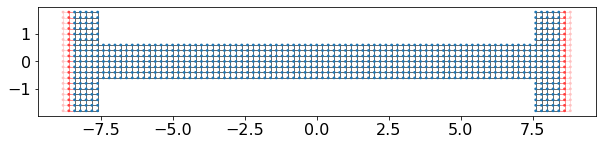

In [6]:
dx = 0.2
Lc = 15
Lx = Lc+2

Wc = 1.5
Wl = 4

sys, cons, fbars = makesys(dx=dx, Lc=Lc, Wc=Wc, Wl=Wl, Lx=Lx)

# define current operators
J0 = kwant.operator.Current(sys)
JX = kwant.operator.Current(sys, np.kron(sx, s0))
JZ = kwant.operator.Current(sys, np.kron(sz, s0))
# up and dw components
Jup = kwant.operator.Current(sys, np.kron((s0+sz)/2, s0))
Jdw = kwant.operator.Current(sys, np.kron((s0-sz)/2, s0))
# +1 and -1 x-components
JXP = kwant.operator.Current(sys, np.kron((s0+sx)/2, s0))
JXM = kwant.operator.Current(sys, np.kron((s0-sx)/2, s0))

# define density operators
D0 = kwant.operator.Density(sys)
DX = kwant.operator.Density(sys, np.kron(sx, s0))
DY = kwant.operator.Density(sys, np.kron(sy, s0))
DZ = kwant.operator.Density(sys, np.kron(sz, s0))
# up and dw components
Dup = kwant.operator.Density(sys, np.kron((s0+sz)/2, s0))
Ddw = kwant.operator.Density(sys, np.kron((s0-sz)/2, s0))
# +1 and -1 x-components
DXP = kwant.operator.Density(sys, np.kron((s0+sx)/2, s0))
DXM = kwant.operator.Density(sys, np.kron((s0-sx)/2, s0))

# plot sys
fig = plt.figure(figsize=(10,2))
plt.rcParams.update({'font.size': 16})
kwant.plot(sys, ax=fig.gca())

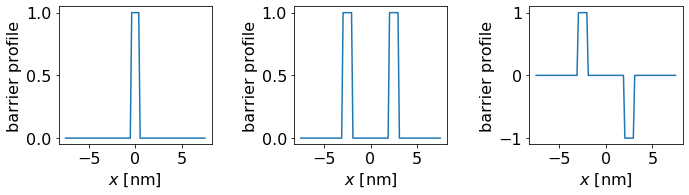

In [7]:
# x range
xr = np.linspace(-Lc/2, Lc/2, 100)
# barriers width
Wb = 1

plt.figure(figsize=(10,3))
plt.rcParams.update({'font.size': 16})

plt.subplot(131)
plt.plot(xr, [fbars(x, 0, 1, Wb, 1) for x in xr])
plt.xlabel(R'$x$ [nm]')
plt.ylabel('barrier profile')

plt.subplot(132)
plt.plot(xr, [fbars(x, 0, 2, Wb, 1) for x in xr])
plt.xlabel(R'$x$ [nm]')
plt.ylabel('barrier profile')

plt.subplot(133)
plt.plot(xr, [fbars(x, 0, 2, Wb, -1) for x in xr])
plt.xlabel(R'$x$ [nm]')
plt.ylabel('barrier profile')

plt.tight_layout()
plt.show()

## Bands of the 2D model: extract 1D model parameters

The hybridization gap is taken directly from the bands at k=0, while for the $\alpha$ we use

$\alpha^2 = |\Delta| \dfrac{\partial^2 \epsilon}{\partial k_{x}^2}\bigg|_{k_{x}=0}$

As we see below, $\alpha \approx 1$ as expected.

At leads, m= 0.025974250836615254 , and alpha= 1.0002611999723605
At const, m= 0.4197745934163444 , and alpha= 1.0204196186757242


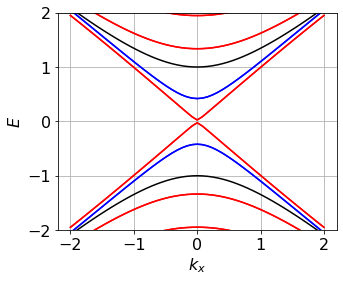

In [8]:
# Extract 1D model parameters m and alpha from the bands of the 2D model

# 1) LEADS
# get function to calculate bands from kwant
bleads = kwant.physics.Bands(sys.leads[0])
# calculate energy, first and second k-derivatives at k=0
ek, vk, ak = bleads(k=0, derivative_order=2)
# hybridization gap m:
mleads = np.min(np.abs(ek))
# velocity alpha:
aleads = np.sqrt(mleads * ak[np.where(ek>0)[0][0]])*dx
print('At leads, m=', mleads, ', and alpha=', aleads)

# 2) CONSTRICTION
# get function to calculate bands from kwant
bcons = kwant.physics.Bands(cons)
# calculate energy, first and second k-derivatives at k=0
ek, vk, ak = bcons(k=0, derivative_order=2)
# hybridization gap m:
mcons = np.min(np.abs(ek))
# velocity alpha:
acons = np.sqrt(mcons * ak[np.where(ek>0)[0][0]])*dx
print('At const, m=', mcons, ', and alpha=', acons)

# And plot the bands

kmax = 2
k = np.linspace(-kmax, kmax, 51)
# bulk analytical solution
bulk = lambda beta, mu, kx: np.sqrt((kx)**2 + (mu-beta*kx**2)**2)
y = bulk(-0.1, -1, k)
# leads and contriction
eleads = np.array([bleads(kx*dx) for kx in k])
econs = np.array([bcons(kx*dx) for kx in k])

plt.figure(figsize=(5,4))
plt.rcParams.update({'font.size': 16})
plt.clf()

plt.plot(k, +y, c='black')
plt.plot(k, -y, c='black')
plt.plot(k, eleads, c='red')
plt.plot(k, econs, c='blue')
plt.ylim(-2,2)
plt.xlabel(R'$k_x$')
plt.ylabel(R'$E$')
plt.grid()

plt.show()

### Compare 1D and 2D models

Let's compare the bands and the transmission obtained with both models without barriers for now.

In [9]:
# build 1D model
sys1D, fbars1D = make1Dmodel(mcons, dx=dx, Lc=Lc)
# define default parameters for the 1D and 2D models for the rest of the calculations
default2D = dict(Nb=0, Wb=Wb, vs=0, vx=0, vz=0, PAP=0, bars=fbars)
default1D = dict(Nb=0, Wb=Wb, vs=0, vx=0, vz=0, PAP=0, bars=fbars1D)

In [10]:
# G from the 2D model
en = np.linspace(0, 1, 200)
G0uu, G0ud, G0du, G0dd = transmission(sys, en, default2D)
Gtot = G0uu + G0ud + G0du + G0dd

100%|██████████| 200/200 [01:08<00:00,  2.91it/s]


In [11]:
# G from the 1D model
G0uu1D, G0ud1D, G0du1D, G0dd1D = transmission(sys1D, en, default1D)
G1D = G0uu1D + G0ud1D + G0du1D + G0dd1D

100%|██████████| 200/200 [00:06<00:00, 30.09it/s]


In [12]:
def set_plot_conf():

    font = {
#         'family' : 'CMU serif',
        'weight' : 'bold',
        'size'   : 25,        
        }
    
    plt.rc('font', **font)  
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    plt.rc('text', usetex=True)

At leads, m= 0.025974250836615254 , and alpha= 1.0002611999723605
At constriction, m= 0.4197745934163444 , and alpha= 1.0204196186757242


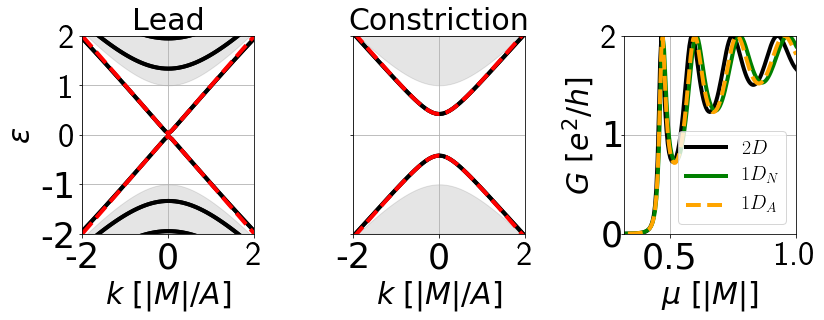

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,5))

lw = 4.0
fontlabel = 30
fonttitle = 30 
fontticks = 35
fontleg = 20

set_plot_conf()
ax1.set_title(R"Lead", fontsize=fonttitle)
ax1.plot(k, eleads, c='black', lw=lw)
ax1.plot(k, +np.sqrt((aleads*k)**2 + mleads**2), c='red', ls='--', lw=lw)
ax1.plot(k, -np.sqrt((aleads*k)**2 + mleads**2), c='red', ls='--', lw=lw)
ax1.fill_between(k, +2, +y, color='black', alpha=0.1)
ax1.fill_between(k, -2, -y, color='black', alpha=0.1)
ax1.tick_params(axis="both", labelsize=fontticks)
ax1.set_ylabel(R"$\epsilon$", fontsize=fontlabel)
ax1.set_yticks(np.arange(-2,2.1,1))
ax1.set_ylim([-2,2])
ax1.set_xlabel(R"$k$ $[|M|/A]$", fontsize=fontlabel)
ax1.set_xticks([-kmax,0,kmax])
ax1.set_xlim([-kmax, kmax])
ax1.grid()

ax2.set_title(R"Constriction", fontsize=fonttitle)
ax2.plot(k, econs, c='black', lw=lw)
ax2.plot(k, +np.sqrt((acons*k)**2 + mcons**2), c='red', ls='--', lw=lw)
ax2.plot(k, -np.sqrt((acons*k)**2 + mcons**2), c='red', ls='--', lw=lw)
ax2.fill_between(k, +2, +y, color='black', alpha=0.1)
ax2.fill_between(k, -2, -y, color='black', alpha=0.1)
ax2.tick_params(axis="both", labelsize=fontticks)
ax2.set_ylim([-2,2])
ax2.set_xlabel(R"$k$ $[|M|/A]$", fontsize=fontlabel)
ax2.set_xticks([-kmax,0,kmax])
ax2.set_xlim([-kmax,kmax])
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.grid()

ax3.plot(en, Gtot, label='$2D$', c='black', lw=lw)
ax3.plot(en, G1D, label='$1D_N$', c='green', lw=lw)
ax3.plot(en, 2*Tmodel1D(en, acons, Lc, mcons), label='$1D_A$', c='orange', ls='--', lw=lw)
ax3.tick_params(axis="both", labelsize=fontticks)
ax3.set_ylabel(R'$G$ [$e^2/h$]', fontsize=fontlabel)
ax3.set_yticks([0,1,2])
ax3.set_ylim([0,2])
ax3.set_xlabel(R'$\mu$ $[|M|]$', fontsize=fontlabel)
ax3.set_xlim([mcons-0.1,1])
ax3.legend(loc='lower right', fontsize=fontleg)
ax3.grid()

plt.tight_layout()
# plt.savefig("bands.svg", bbox_inches='tight')

print('At leads, m=', mleads, ', and alpha=', aleads)
print('At constriction, m=', mcons, ', and alpha=', acons)

### Above:

The first two panels show the lead and constriction bands with the bulk bands show in gray for reference. The red dashed lines are the dispersion from the simplified 1D model.

On the third pannel we compare the conductances G obtained with the 2D and 1D models (numerical and analytical). They match well within the bulk gap $|\mu| < 1$ and the differences only appear when the first bulk band starts to contribute in the 2D model, which is beyond the description of the 1D model that only account for the edge states within the bulk gap.

## Analyzing the conductance for differents parameters and Temperature

In [14]:
def Gmu(T, mu, n, Lc, delta, epts=len(en)):
        
    kT = T
    en = np.linspace(mu-n*kT, mu+n*kT, epts)
    
    dfde = lambda en,mu: -(1/kT)*(np.exp((en-mu)/(kT))/(1+np.exp((en-mu)/(kT)))**2)  
    
    tr = np.array(Tmodel1D(en, alpha=1, Lc=Lc, Delta=delta))

    g  = 2*integrate.simps(-tr*dfde(en,mu), x=en) 

    return g

              
def G1D_withT(T, n, Lc, delta, mumin=0, mumax=2, mupts=len(en), epts=len(en)):
    
    mu_range = np.linspace(mumin, mumax, mupts)
    G = np.array([Gmu(T, mu, n, Lc, delta) for mu in tqdm(mu_range)])
    
    return G, mu_range

In [15]:
# Constriction length
Lc1=5
Lc2=10
Lc3=15
Lc4=20
Lc5=25

# Alpha = for all Wc we found alpha aprox 1
alpha = 1.0

# Gap Delta. For dx=0.2 we have

delta1 = 0.42 # Wc = 1.5
delta2 = 0.25 # Wc = 1.7
delta3 = 0.25 # Wc = 2.0
delta4 = 0.10 # Wc = 2.5
delta5 = 0.06 # Wc = 3.0


# Varying the GAP
tr1_ = []*len(en)
tr2_ = []*len(en)
tr3_ = []*len(en)
tr4_ = []*len(en)
tr5_ = []*len(en)
# Varying the Lc
tr1  = []*len(en)
tr2  = []*len(en)
tr3  = []*len(en)
tr4  = []*len(en)
tr5  = []*len(en)

for ek in tqdm(en):
    # Fixed Lc 
    tr1_ = np.append(tr1_, Tmodel1D(ek, alpha=alpha, Lc=Lc3, Delta=delta1))
    tr2_ = np.append(tr2_, Tmodel1D(ek, alpha=alpha, Lc=Lc3, Delta=delta2))
    tr3_ = np.append(tr3_, Tmodel1D(ek, alpha=alpha, Lc=Lc3, Delta=delta3))
    tr4_ = np.append(tr4_, Tmodel1D(ek, alpha=alpha, Lc=Lc3, Delta=delta4))
    tr5_ = np.append(tr5_, Tmodel1D(ek, alpha=alpha, Lc=Lc3, Delta=delta5))

    # Fixed GAP 
    tr1 = np.append(tr1, Tmodel1D(ek, alpha=alpha, Lc=Lc1, Delta=delta1))
    tr2 = np.append(tr2, Tmodel1D(ek, alpha=alpha, Lc=Lc2, Delta=delta1))
    tr3 = np.append(tr3, Tmodel1D(ek, alpha=alpha, Lc=Lc3, Delta=delta1))
    tr4 = np.append(tr4, Tmodel1D(ek, alpha=alpha, Lc=Lc4, Delta=delta1))
    tr5 = np.append(tr5, Tmodel1D(ek, alpha=alpha, Lc=Lc5, Delta=delta1))

100%|██████████| 200/200 [00:00<00:00, 5357.80it/s]


In [16]:
# With temperature
T = [0.01, 0.03, 0.05]
G1D_T1, mu = G1D_withT(T[0], n=5, Lc=Lc3, delta=delta1)
G1D_T2, mu = G1D_withT(T[1], n=5, Lc=Lc3, delta=delta1)
G1D_T3, mu = G1D_withT(T[2], n=5, Lc=Lc3, delta=delta1)

100%|██████████| 200/200 [00:00<00:00, 3453.54it/s]


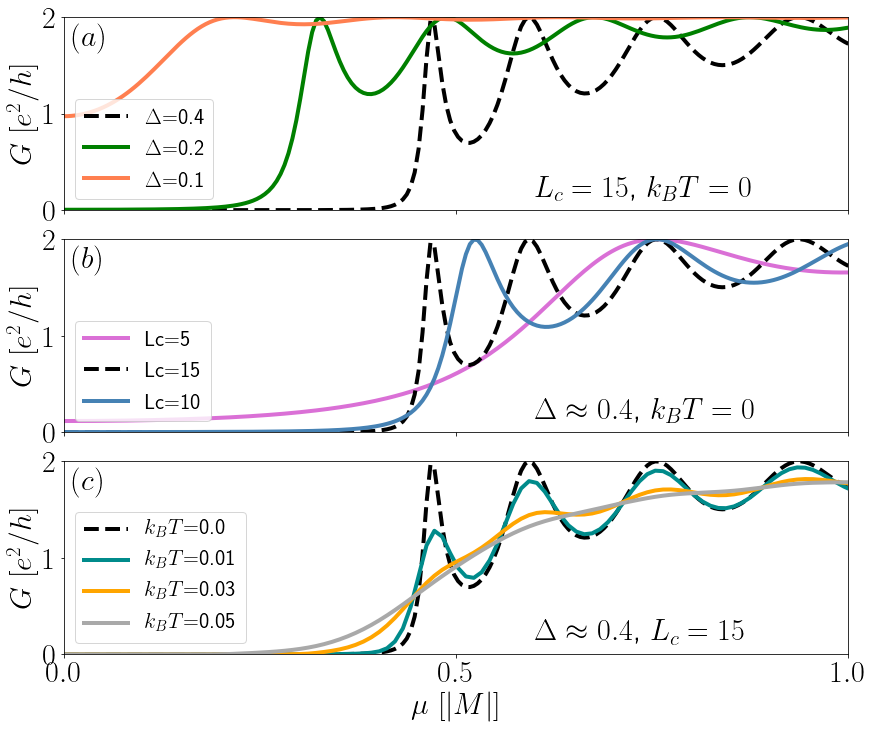

In [17]:
fig, ax = plt.subplots(3,1, sharey=True, sharex=True, figsize=(12,10));

lw = 4.0
font_ticks = 30
font_label = 30
font_leg = 22

set_plot_conf()
for i in range(3):
    
    ax[i].tick_params(axis="both", labelsize=font_ticks)
    ax[i].set_ylabel(R"$G$ $[e^2/h]$", fontsize=font_label)
    ax[i].set_yticks(np.arange(0,3.0,1.0))
    ax[i].set_ylim(0,2)
    ax[2].set_xlabel(R"$\mu$ $[|M|]$", fontsize=font_label)
    ax[i].set_xticks(np.arange(0,1.5,0.5))
    ax[i].set_xlim(0,1)

ax[0].text(x=0.01, y=1.7, s=R'$(a)$', usetex=True, fontsize=30)
ax[0].text(x=0.60, y=0.1, s=R'$L_{c}=15$, $k_{B}T=0$', usetex=True, fontsize=30)
ax[0].plot(en, 2*tr1_, label=R'$\Delta$='+str(round(delta1,1)), linewidth=lw, linestyle='--', c='black')
ax[0].plot(en, 2*tr3_, label=R'$\Delta$='+str(round(delta3,1)), linewidth=lw, linestyle='-',  c='green')
ax[0].plot(en, 2*tr5_, label=R'$\Delta$='+str(round(delta5,1)), linewidth=lw, linestyle='-', c='coral')
ax[0].legend(loc='lower left', fontsize=font_leg)

ax[1].text(x=0.01, y=1.7, s=R'$(b)$', usetex=True, fontsize=30)
ax[1].text(x=0.60, y=0.1, s=R'$\Delta\approx 0.4$, $k_{B}T=0$', usetex=True, fontsize=30)
ax[1].plot(en, 2*tr1, label='Lc='+str(Lc1), linewidth=lw, linestyle='-',  c='orchid')
ax[1].plot(en, 2*tr3, label='Lc='+str(Lc3), linewidth=lw, linestyle='--', c='black')
ax[1].plot(en, 2*tr2, label='Lc='+str(Lc2), linewidth=lw, linestyle='-',  c='steelblue')
ax[1].legend(loc='lower left', fontsize=font_leg)

ax[2].text(x=0.01, y=1.7, s=R'$(c)$', usetex=True, fontsize=30)
ax[2].text(x=0.60, y=0.1, s=R'$\Delta\approx 0.4$, $L_{c}=15$', usetex=True, fontsize=30)
ax[2].plot(en, 2*tr3, label=R'$k_{B}T$=0.0', linewidth=lw, linestyle='--', c='black')
ax[2].plot(mu, G1D_T1, label=R'$k_{B}T$='+str(T[0]), linewidth=lw, linestyle="-",  c='darkcyan')
ax[2].plot(mu, G1D_T2, label=R'$k_{B}T$='+str(T[1]), linewidth=lw, linestyle="-",  c="orange");
ax[2].plot(mu, G1D_T3, label=R'$k_{B}T$='+str(T[2]), linewidth=lw, linestyle="-",  c="darkgray")
ax[2].legend(loc='lower left', fontsize=font_leg)

plt.tight_layout(pad=0.1)
# plt.savefig("G_with_T_Lc.svg")

## Current densities: 0 barriers

At the peaks, the current density for each spin channel show vortices. This are formed as the electron cross the constriction through one edge, reflects at the ends of the constriction and comes back through the opposite edge, thus forming vortex patterns. The same occurs at the second peak, but to phase interference there's a node at the center.

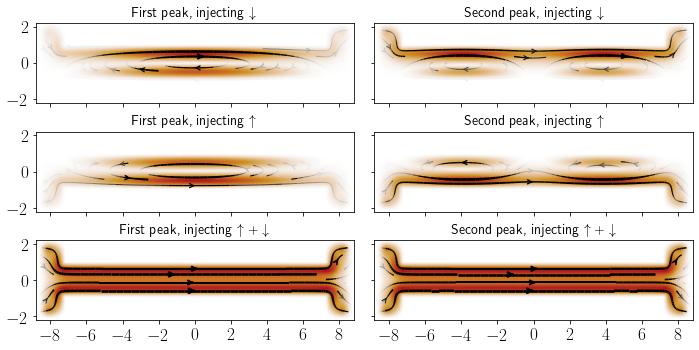

In [18]:
peaks0 = find_peaks(Gtot)[0]
psi0 = kwant.wave_function(sys, energy=en[peaks0[0]], params=default2D)(0)
psi1 = kwant.wave_function(sys, energy=en[peaks0[1]], params=default2D)(0)

# choose which current density to run: 
#  J0  : charge
#  JZ  : sigma_z projection = up - dw
#  JX  : sigma_x projection = (+x) - (-x)
#  Jup : spin up component
#  Jdw : spin dw component
#  JXP : spin (+x) component
#  JXM : spin (-x) component
Jop = J0

fig, ax = plt.subplots(3,2, sharex=True, sharey=True, figsize=(10,5))
plt.rcParams.update({'font.size': 16})

current = Jop(psi0[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0])
ax[0,0].set_title(R"First peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi0[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0])
ax[1,0].set_title(R"First peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi0)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0])
ax[2,0].set_title(R"First peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi1[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1])
ax[0,1].set_title(R"Second peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi1[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1])
ax[1,1].set_title(R"Second peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi1)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1])
ax[2,1].set_title(R"Second peak, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

## Densities: 0 barriers

Might be easier to visualize and understand.

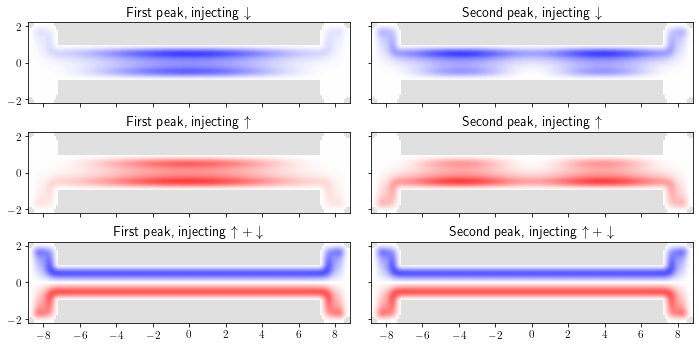

In [19]:
peaks0 = find_peaks(Gtot)[0]
psi0 = kwant.wave_function(sys, energy=en[peaks0[0]], params=default2D)(0)
psi1 = kwant.wave_function(sys, energy=en[peaks0[1]], params=default2D)(0)

# choose which density to run: 
#  D0  : charge
#  DZ  : sigma_z projection = up - dw
#  DX  : sigma_x projection = (+x) - (-x)
#  Dup : spin up component
#  Ddw : spin dw component
#  DXP : spin (+x) component
#  DXM : spin (-x) component
Dop = DZ
fsat = 10 # saturation factor for color scale

fig, ax = plt.subplots(3,2, sharex=True, sharey=True, figsize=(10,5))
plt.rcParams.update({'font.size': 16})

density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[0,0], vmin=-vmax, vmax=vmax, cmap='bwr')
ax[0,0].set_title(R"First peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[1,0], vmin=-vmax, vmax=vmax, cmap='bwr')
ax[1,0].set_title(R"First peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[2,0], vmin=-vmax, vmax=vmax, cmap='bwr')
ax[2,0].set_title(R"First peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[0,1], vmin=-vmax, vmax=vmax, cmap='bwr')
ax[0,1].set_title(R"Second peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[1,1], vmin=-vmax, vmax=vmax, cmap='bwr')
ax[1,1].set_title(R"Second peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[2,1], vmin=-vmax, vmax=vmax, cmap='bwr')
ax[2,1].set_title(R"Second peak, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

## Current + Density: 0 Barrier

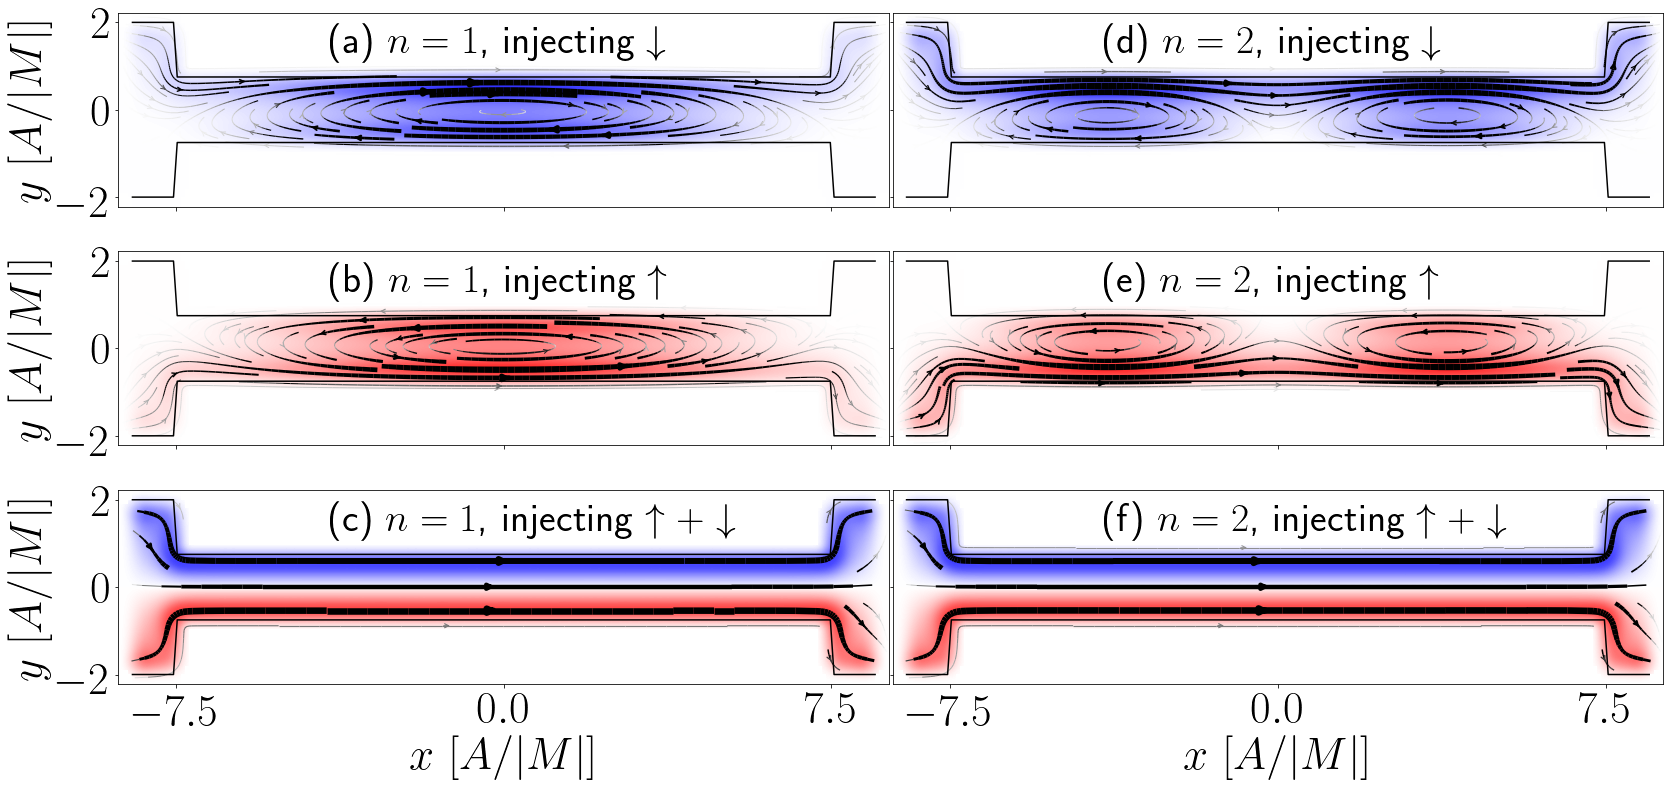

In [20]:
def const_shape(x, Lc, Wc, Wl):
    if np.abs(x) < Lc/2:
        return(Wc/2)
    else:
        return(Wl/2)
    

arrow_density = 0.55 #0.2 defaut
max_lw = 6.5 # 3=default

Jop = J0
Dop = DZ
cmap = 'bwr'
fsat = 9

fig, ax = plt.subplots(3,2, sharex=True, sharey=True, figsize=(23,11))

x = np.linspace(-Lx/2, Lx/2, 200)
y = np.array([const_shape(xi, Lc, Wc, Wl) for xi in x])

font_ticks = 45
font_label = 45
font_title = 40
font_leg = 22

# set_plot_conf()
for i in range(3):
    for j in range(2):
        ax[i,j].plot(x, +y, c='black')
        ax[i,j].plot(x, -y, c='black')
        
        ax[i,j].tick_params(axis="both", labelsize=font_ticks)
        ax[i,0].set_ylabel(R"$y$ $[A/|M|]$", fontsize=font_label)
        ax[2,j].set_xlabel(R"$x$ $[A/|M|]$", fontsize=font_label)
        ax[2,j].set_xticks([-Lc/2,0,Lc/2])
        

current = Jop(psi0[0])
density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[0,0], vmin=-vmax, vmax=vmax, cmap=cmap)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,0].text(x=-4, y=1.3, s=R"(a) $n=1$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi0[1])
density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[1,0], vmin=-vmax, vmax=vmax, cmap=cmap)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,0].text(x=-4, y=1.3, s=R"(b) $n=1$, injecting $\uparrow$", fontsize=font_title)

current = sum(Jop(p) for p in psi0)
density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[2,0], vmin=-vmax, vmax=vmax, cmap=cmap)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,0].text(x=-4, y=1.3, s=R"(c) $n=1$, injecting $\uparrow + \downarrow$", fontsize=font_title)

# #
current = Jop(psi1[0])
density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[0,1], vmin=-vmax, vmax=vmax, cmap=cmap)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,1].text(x=-4, y=1.3, s=R"(d) $n=2$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi1[1])
density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[1,1], vmin=-vmax, vmax=vmax, cmap=cmap)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,1].text(x=-4, y=1.3, s=R"(e) $n=2$, injecting $\uparrow$", fontsize=font_title)

current = sum(Jop(p) for p in psi1)
density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, ax=ax[2,1], vmin=-vmax, vmax=vmax, cmap=cmap)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,1].text(x=-4, y=1.3, s=R"(f) $n=2$, injecting $\uparrow + \downarrow$", fontsize=font_title)

plt.tight_layout(pad=0)
# plt.savefig("0bar-currentdensity.png")
# plt.savefig("0 BAR - Density DZ.svg")

# One barrier

In [21]:
en = np.linspace(mcons-0.1, 1, 200) #301
vi = 0.3 # common intensity

# no bars
params0 = dict(default2D)
G0uu, G0ud, G0du, G0dd, P00, P0x, P0y, P0z = transmission(sys, en, params0, polarizations=True)

# one bar: vs
paramsS = dict(default2D, Nb=1, vs=vi)
GSuu, GSud, GSdu, GSdd, PS0, PSx, PSy, PSz = transmission(sys, en, paramsS, polarizations=True)

# one bar: vx
paramsX = dict(default2D, Nb=1, vx=vi)
GXuu, GXud, GXdu, GXdd, PX0, PXx, PXy, PXz = transmission(sys, en, paramsX, polarizations=True)

# one bar: vz
paramsZ = dict(default2D, Nb=1, vz=vi)
GZuu, GZud, GZdu, GZdd, PZ0, PZx, PZy, PZz  = transmission(sys, en, paramsZ, polarizations=True)

100%|██████████| 200/200 [00:57<00:00,  3.48it/s]


In [22]:
# total G
G0 = G0uu + G0ud + G0du + G0dd
GS = GSuu + GSud + GSdu + GSdd
GX = GXuu + GXud + GXdu + GXdd
GZ = GZuu + GZud + GZdu + GZdd

# capture peaks postions
peaks0 = find_peaks(G0)[0]
peaksS = find_peaks(GS)[0]
peaksX = find_peaks(GX)[0]
peaksZ = find_peaks(GZ)[0]

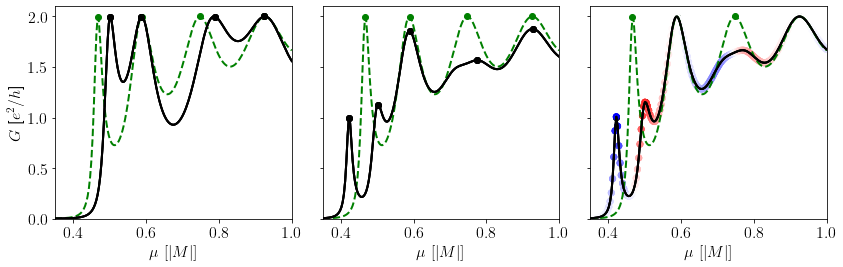

In [23]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,4))

# plot manipulation
font_legend = 14
font_ticks  = 16
font_text = 16
font_axis_label = 16
colorref  = 'green'
linewidth = 2
color = 'black'

for i in range(3):
    
    ## no bar
    ax[i].plot(en, G0, label='no bar',  c=colorref, lw=linewidth, ls='--')
    ax[i].scatter(en[peaks0], G0[peaks0], c=colorref)
    
    ## nu=s
    ax[0].plot(en, GS, label=R'$\nu=0$', c=color, lw=linewidth)
    ax[0].scatter(en[peaksS], GS[peaksS], c=color)
    
    ## nu=x
    ax[1].plot(en, GX, label=R'$\nu=x$', c=color, lw=linewidth)
    ax[1].scatter(en[peaksX], GX[peaksX], c=color)
    
    ## nu=z
    ax[2].plot(en, GZ, label='1Z', c=color, lw=linewidth)
    ax[2].scatter(en[peaksZ], GZ[peaksZ],c=color)
    ax[2].scatter(en, GZ, c=PZz.real, cmap='bwr', vmin=-1, vmax=+1)
    
    ## general settings
    ax[i].tick_params(axis="both", labelsize = font_ticks)
    ax[i].set_xlabel(R"$\mu$ $[|M|]$", fontsize = font_axis_label)
    ax[i].set_ylim(0, 2.1)
    ax[i].set_xlim(0.35, 1.0)

ax[0].set_ylabel(R"$G$ [$e^2/h$]", fontsize = font_axis_label)    
plt.tight_layout()

## Above: 1 barrier results

**S-bar:** odd peaks shift, even peaks stay still due to node.

**X-bar:** odd peaks hybridize into approximate eigenstates of $s_x \rightarrow \pm 1$. More clearly seen in the first peak.

**Z-bar:** odd peaks split into eigenstates of $s_z \rightarrow \pm 1$. More clearly seen in the first peak.

### Current densities: 1 barrier S

The results here are nearly identical to the case without barriers. The only significant effect is that the barrier shifts the resonance in energy, but it does not affect **qualitiativelly** the features of the current density. The node at the center of the second peak reduces the effect of the barrier that is located there and the second peak does not shift in energy.

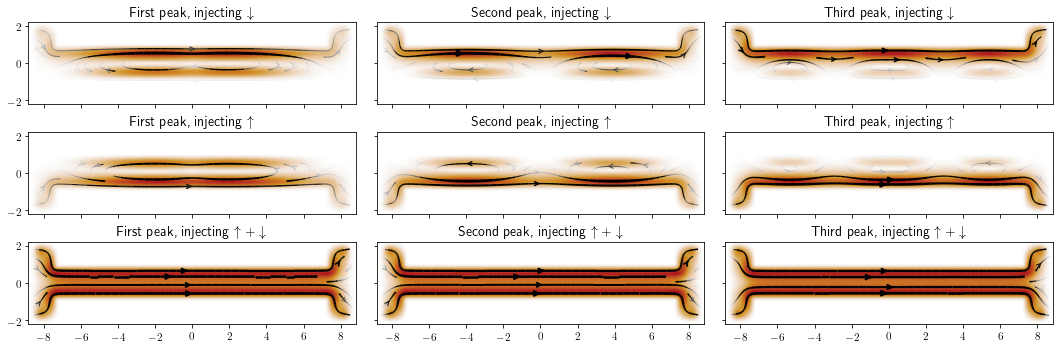

In [24]:
psi0 = kwant.wave_function(sys, energy=en[peaksS[0]], params=paramsS)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksS[1]], params=paramsS)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksS[2]], params=paramsS)(0)

# choose which current density to run: 
#  J0  : charge
#  JZ  : sigma_z projection = up - dw
#  JX  : sigma_x projection = (+x) - (-x)
#  Jup : spin up component
#  Jdw : spin dw component
#  JXP : spin (+x) component
#  JXM : spin (-x) component
Jop = J0

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,5))

current = Jop(psi0[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0])
ax[0,0].set_title(R"First peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi0[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0])
ax[1,0].set_title(R"First peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi0)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0])
ax[2,0].set_title(R"First peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi1[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1])
ax[0,1].set_title(R"Second peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi1[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1])
ax[1,1].set_title(R"Second peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi1)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1])
ax[2,1].set_title(R"Second peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi2[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,2])
ax[0,2].set_title(R"Third peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi2[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,2])
ax[1,2].set_title(R"Third peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi2)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,2])
ax[2,2].set_title(R"Third peak, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

### Densities: 1 barrier S

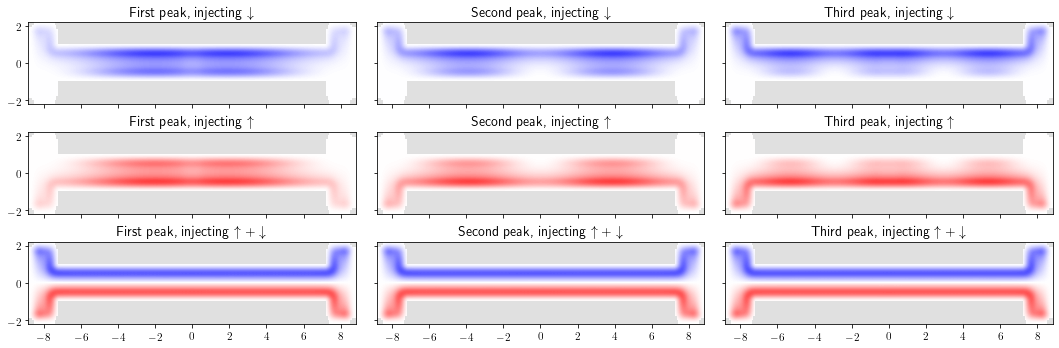

In [25]:
psi0 = kwant.wave_function(sys, energy=en[peaksS[0]], params=paramsS)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksS[1]], params=paramsS)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksS[2]], params=paramsS)(0)

# choose which density to run: 
#  D0  : charge
#  DZ  : sigma_z projection = up - dw
#  DX  : sigma_x projection = (+x) - (-x)
#  Dup : spin up component
#  Ddw : spin dw component
#  DXP : spin (+x) component
#  DXM : spin (-x) component
Dop = DZ
fsat = 10 # saturation factor for color scale

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,5))

density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap='bwr', ax=ax[0,0])
ax[0,0].set_title(R"First peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap='bwr', ax=ax[1,0])
ax[1,0].set_title(R"First peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap='bwr', ax=ax[2,0])
ax[2,0].set_title(R"First peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap='bwr', ax=ax[0,1])
ax[0,1].set_title(R"Second peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap='bwr', ax=ax[1,1])
ax[1,1].set_title(R"Second peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap='bwr', ax=ax[2,1])
ax[2,1].set_title(R"Second peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi2[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap='bwr', ax=ax[0,2])
ax[0,2].set_title(R"Third peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi2[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap='bwr', ax=ax[1,2])
ax[1,2].set_title(R"Third peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi2); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap='bwr', ax=ax[2,2])
ax[2,2].set_title(R"Third peak, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

### Current densities: 1 barrier X

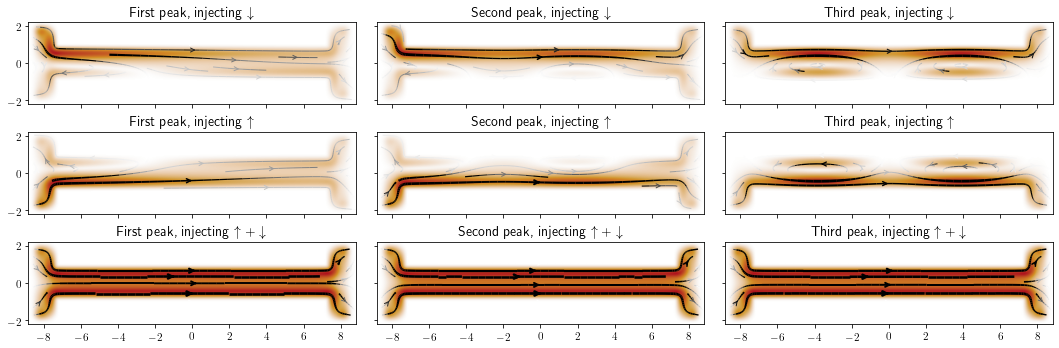

In [26]:
psi0 = kwant.wave_function(sys, energy=en[peaksX[0]], params=paramsX)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksX[1]], params=paramsX)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksX[2]], params=paramsX)(0)

# choose which current density to run: 
#  J0  : charge
#  JZ  : sigma_z projection = up - dw
#  JX  : sigma_x projection = (+x) - (-x)
#  Jup : spin up component
#  Jdw : spin dw component
#  JXP : spin (+x) component
#  JXM : spin (-x) component
Jop = J0

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,5))

current = Jop(psi0[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0])
ax[0,0].set_title(R"First peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi0[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0])
ax[1,0].set_title(R"First peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi0)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0])
ax[2,0].set_title(R"First peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi1[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1])
ax[0,1].set_title(R"Second peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi1[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1])
ax[1,1].set_title(R"Second peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi1)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1])
ax[2,1].set_title(R"Second peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi2[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,2])
ax[0,2].set_title(R"Third peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi2[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,2])
ax[1,2].set_title(R"Third peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi2)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,2])
ax[2,2].set_title(R"Third peak, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

### Densities: 1 bar X

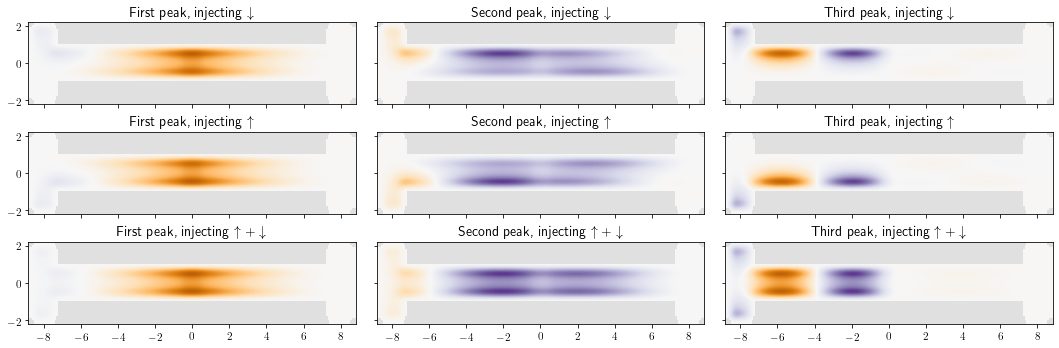

In [27]:
psi0 = kwant.wave_function(sys, energy=en[peaksX[0]], params=paramsX)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksX[1]], params=paramsX)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksX[2]], params=paramsX)(0)

# choose which density to run: 
#  D0  : charge
#  DZ  : sigma_z projection = up - dw
#  DX  : sigma_x projection = (+x) - (-x)
#  Dup : spin up component
#  Ddw : spin dw component
#  DXP : spin (+x) component
#  DXM : spin (-x) component
Dop = DX
fsat = 10 # saturation factor for color scale
cmap = 'PuOr'

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,5))

density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,0])
ax[0,0].set_title(R"First peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,0])
ax[1,0].set_title(R"First peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,0])
ax[2,0].set_title(R"First peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,1])
ax[0,1].set_title(R"Second peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,1])
ax[1,1].set_title(R"Second peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,1])
ax[2,1].set_title(R"Second peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi2[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,2])
ax[0,2].set_title(R"Third peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi2[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,2])
ax[1,2].set_title(R"Third peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi2); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,2])
ax[2,2].set_title(R"Third peak, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

### Current + Density: 1 Barrier X

In [28]:
def const_shape(x, Lc, Wc, Wl):
    if np.abs(x) < Lc/2:
        return(Wc/2)
    else:
        return(Wl/2)
    
x = np.linspace(-Lx/2, Lx/2, 200)
y = np.array([const_shape(xi, Lc, Wc, Wl) for xi in x])

psi0 = kwant.wave_function(sys, energy=en[peaksX[0]], params=paramsX)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksX[1]], params=paramsX)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksX[2]], params=paramsX)(0)

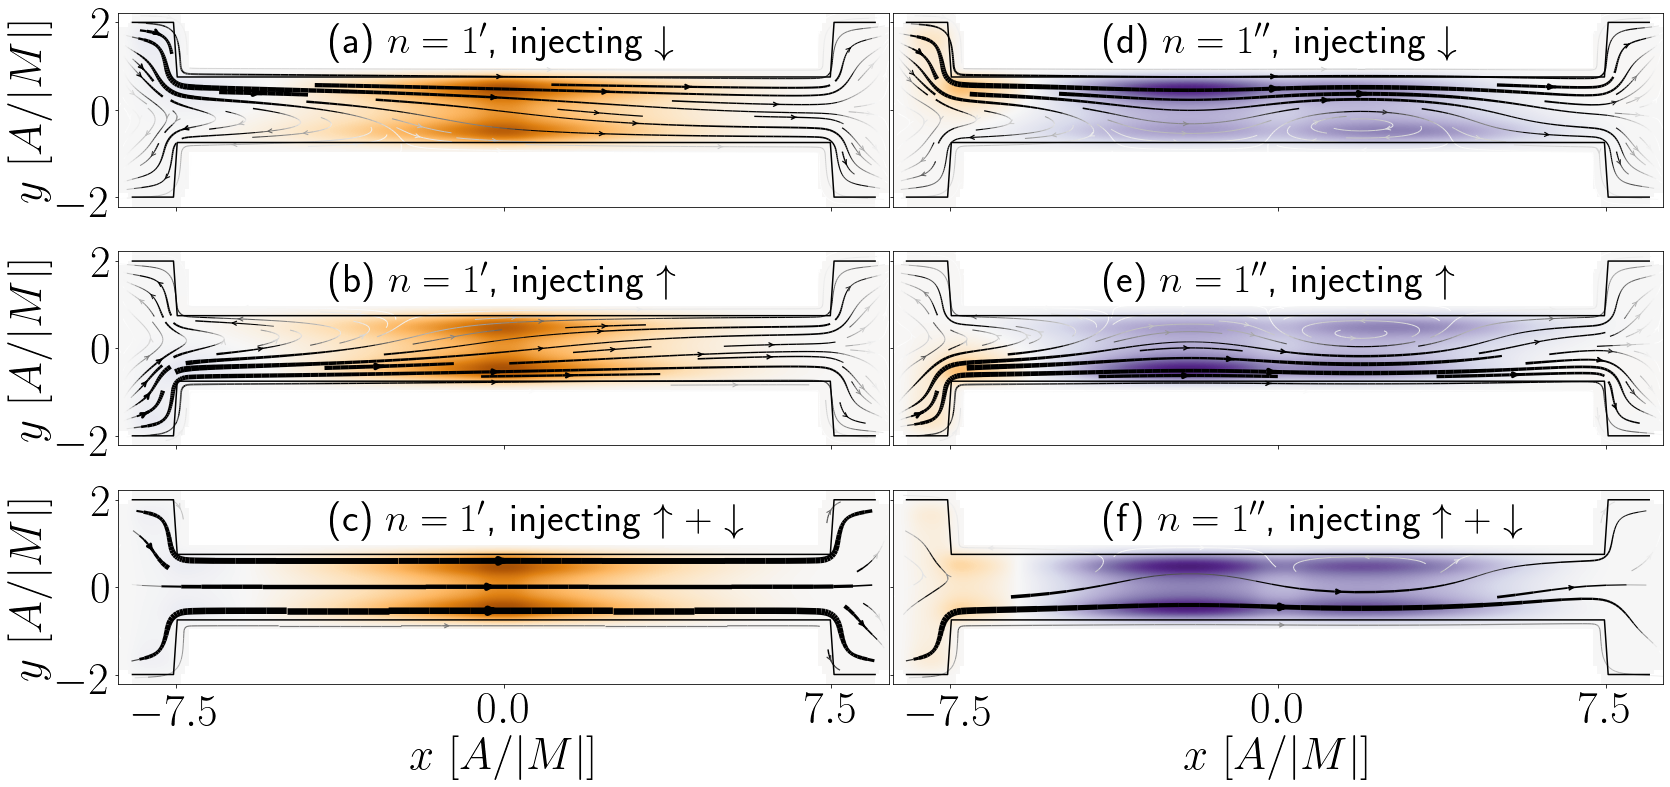

In [29]:
fig, ax = plt.subplots(3,2, sharex=True, sharey=True, figsize=(23,11))

font_ticks = 45
font_label = 45
font_title = 40
font_leg = 22

arrow_density = 0.5 #0.2 defaut
max_lw = 6 # 3=default

Jop = J0
Dop = DX
fsat = 9
cmap = 'PuOr'

# set_plot_conf()
for i in range(3):
    for j in range(2):
        ax[i,j].plot(x, +y, c='black')
        ax[i,j].plot(x, -y, c='black')
        
        ax[i,j].tick_params(axis="both", labelsize=font_ticks)
        ax[i,0].set_ylabel(R"$y$ $[A/|M|]$", fontsize=font_label)
        ax[2,j].set_xlabel(R"$x$ $[A/|M|]$", fontsize=font_label)
        ax[2,j].set_xticks([-Lc/2,0,Lc/2])
        
        
current = Jop(psi0[0])
density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,0].text(x=-4, y=1.3, s=R"(a) $n=1^{\prime}$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi0[1])
density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,0].text(x=-4, y=1.3, s=R"(b) $n=1^{\prime}$, injecting $\uparrow$", fontsize=font_title)

current = sum(Jop(p) for p in psi0)
density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,0].text(x=-4, y=1.3, s=R"(c) $n=1^{\prime}$, injecting $\uparrow + \downarrow$", fontsize=font_title)

#
current = Jop(psi1[0])
density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,1].text(x=-4, y=1.3, s=R"(d) $n=1^{\prime\prime}$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi1[1])
density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,1].text(x=-4, y=1.3, s=R"(e) $n=1^{\prime\prime}$, injecting $\uparrow$", fontsize=font_title)

density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,1].text(x=-4, y=1.3, s=R"(f) $n=1^{\prime\prime}$, injecting $\uparrow + \downarrow$", fontsize=font_title)

# plt.savefig("1Xbar-currentdensity.svg")
plt.tight_layout(pad=0)
plt.show()

### Current densities: 1 barrier Z

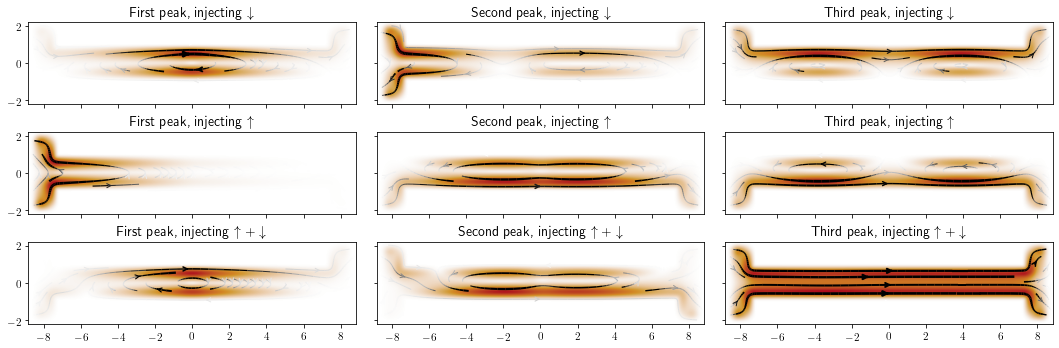

In [30]:
psi0 = kwant.wave_function(sys, energy=en[peaksZ[0]], params=paramsZ)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksZ[1]], params=paramsZ)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksZ[2]], params=paramsZ)(0)

# choose which current density to run: 
#  J0  : charge
#  JZ  : sigma_z projection = up - dw
#  JX  : sigma_x projection = (+x) - (-x)
#  Jup : spin up component
#  Jdw : spin dw component
#  JXP : spin (+x) component
#  JXM : spin (-x) component
Jop = J0

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,5))

current = Jop(psi0[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0])
ax[0,0].set_title(R"First peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi0[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0])
ax[1,0].set_title(R"First peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi0)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0])
ax[2,0].set_title(R"First peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi1[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1])
ax[0,1].set_title(R"Second peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi1[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1])
ax[1,1].set_title(R"Second peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi1)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1])
ax[2,1].set_title(R"Second peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi2[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,2])
ax[0,2].set_title(R"Third peak, injecting $\downarrow$", fontsize=14)

current = Jop(psi2[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,2])
ax[1,2].set_title(R"Third peak, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi2)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,2])
ax[2,2].set_title(R"Third peak, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

### Densities: 1 bar Z

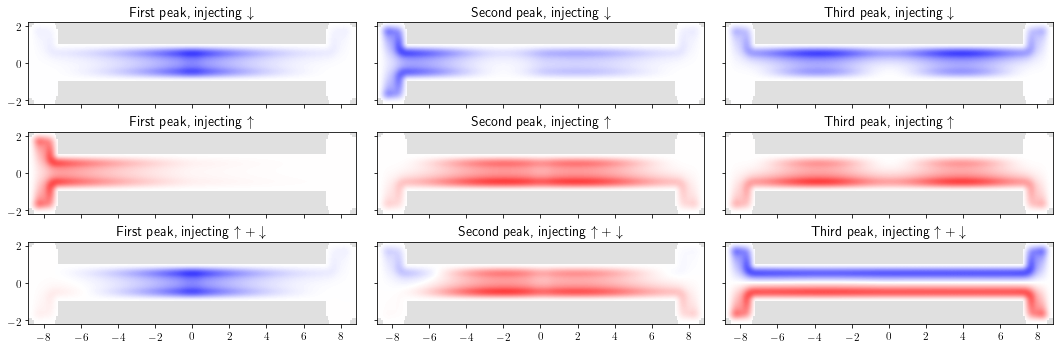

In [31]:
psi0 = kwant.wave_function(sys, energy=en[peaksZ[0]], params=paramsZ)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksZ[1]], params=paramsZ)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksZ[2]], params=paramsZ)(0)

# choose which density to run: 
#  D0  : charge
#  DZ  : sigma_z projection = up - dw
#  DX  : sigma_x projection = (+x) - (-x)
#  Dup : spin up component
#  Ddw : spin dw component
#  DXP : spin (+x) component
#  DXM : spin (-x) component
Dop = DZ
fsat = 10 # saturation factor for color scale
cmap = 'bwr'

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,5))

density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,0])
ax[0,0].set_title(R"First peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,0])
ax[1,0].set_title(R"First peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,0])
ax[2,0].set_title(R"First peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,1])
ax[0,1].set_title(R"Second peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,1])
ax[1,1].set_title(R"Second peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,1])
ax[2,1].set_title(R"Second peak, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi2[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,2])
ax[0,2].set_title(R"Third peak, injecting $\downarrow$", fontsize=14)

density = Dop(psi2[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,2])
ax[1,2].set_title(R"Third peak, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi2); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,2])
ax[2,2].set_title(R"Third peak, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

### Current + Density: 1 Barrier Z

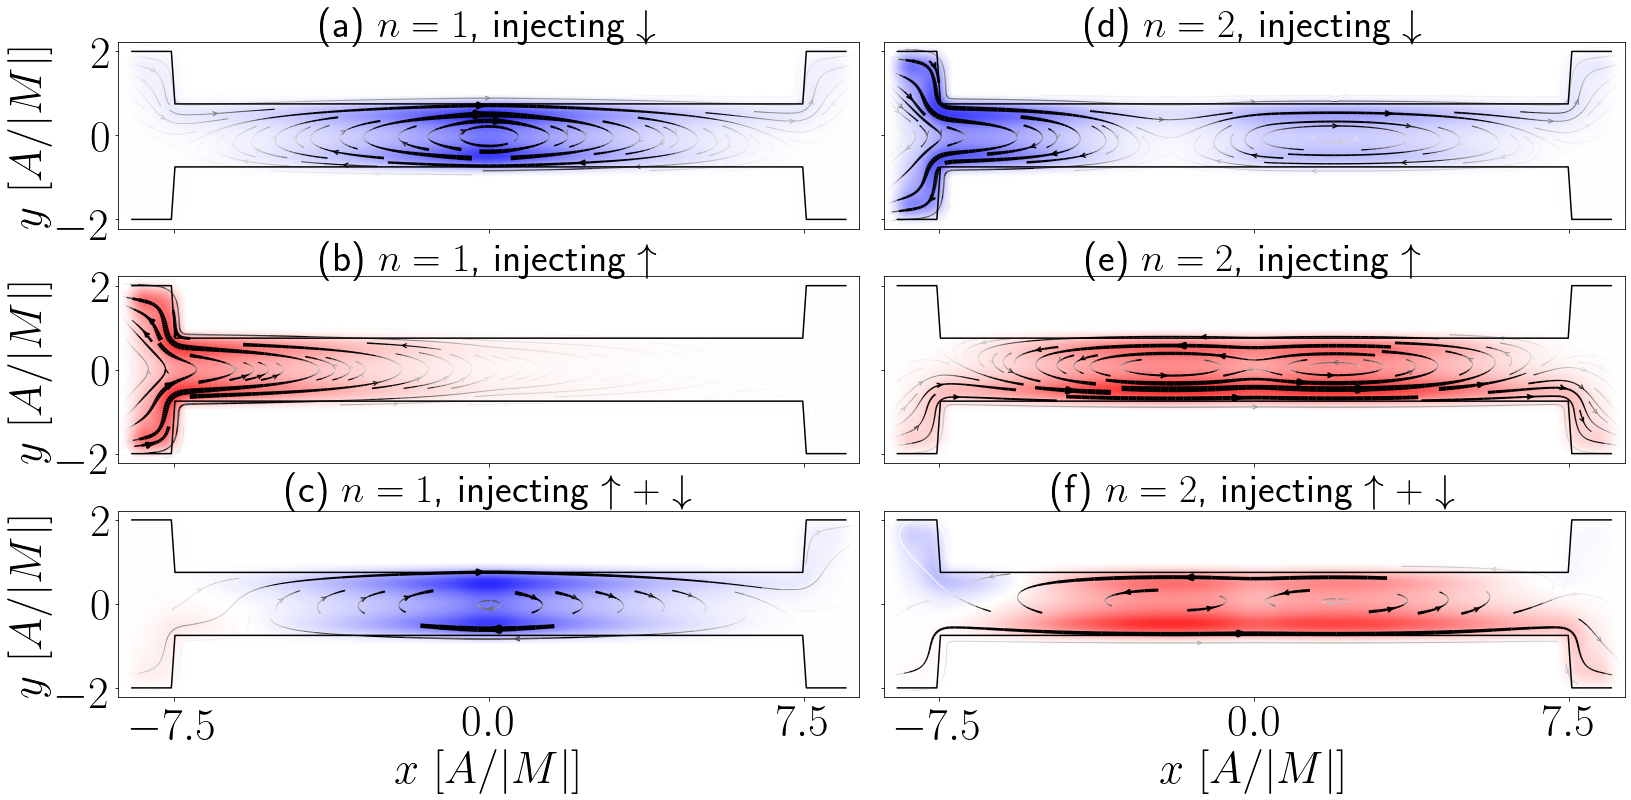

In [32]:
def const_shape(x, Lc, Wc, Wl):
    if np.abs(x) < Lc/2:
        return(Wc/2)
    else:
        return(Wl/2)
    
x = np.linspace(-Lx/2, Lx/2, 200)
y = np.array([const_shape(xi, Lc, Wc, Wl) for xi in x])

fig, ax = plt.subplots(3,2, sharex=True, sharey=True, figsize=(23,11))

font_ticks = 45
font_label = 45
font_title = 40
font_leg = 22

arrow_density = 0.5 #0.2 defaut
max_lw = 6 # 3=default

Jop = J0
Dop = DZ
fsat = 9
cmap = 'bwr'

# set_plot_conf()
for i in range(3):
    for j in range(2):
        ax[i,j].plot(x, +y, c='black')
        ax[i,j].plot(x, -y, c='black')
        
        ax[i,j].tick_params(axis="both", labelsize=font_ticks)
        ax[i,0].set_ylabel(R"$y$ $[A/|M|]$", fontsize=font_label)
        ax[2,j].set_xlabel(R"$x$ $[A/|M|]$", fontsize=font_label)
        ax[2,j].set_xticks([-Lc/2,0,Lc/2])
        
        
current = Jop(psi0[0])
density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,0].set_title(R"(a) $n=1$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi0[1])
density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,0].set_title(R"(b) $n=1$, injecting $\uparrow$", fontsize=font_title)

current = sum(Jop(p) for p in psi0)
density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,0].set_title(R"(c) $n=1$, injecting $\uparrow + \downarrow$", fontsize=font_title)

#
current = Jop(psi1[0])
density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,1].set_title(R"(d) $n=2$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi1[1])
density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,1].set_title(R"(e) $n=2$, injecting $\uparrow$", fontsize=font_title)

density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,1].set_title(R"(f) $n=2$, injecting $\uparrow + \downarrow$", fontsize=font_title)

plt.tight_layout()
plt.savefig("1Z BAR - Density DZ")
plt.show()

# Band structure - 1 Barrier

In [33]:
def eig(kx, delta, gamma=-0.1, V=[0,0,0,0]):
       
    vs=V[0]
    vx=V[1]
    vy=V[2]
    vz=V[3]
    
    H0  = kx*np.kron(sz, sx) + (delta - gamma*(kx**2))*np.kron(s0,sz) + 0j
    H0 += np.kron(vs*s0 + vx*sx + vz*sz, s0)

    return np.linalg.eigh(H0)

def eig_aux(kx, delta, gamma=-0.1, V=[0,0,0,0], en=False):

    autovec = np.array([])
    autoval = np.array([])
    for kx_aux in tqdm(kx):
        solve = eig(kx_aux, delta, V=V)
        autoval = np.append(autoval, solve[0])
        autovec = np.append(autovec, solve[1].T)
   
    # ordena os autovetores de 4 em 4
    vec_aux = [[]]*4*kpts
    for i in range(4*kpts):
        vec_aux[i] = autovec[4*i:4*(i+1)]
    
    if en == True:
        S0 = []
        for i in range(4*kpts):
            S0_aux = np.vdot(vec_aux[i], np.dot(np.kron(s0, s0), vec_aux[i]))
            S0 = np.append(S0, S0_aux)
        return autoval.reshape(kpts, 4), S0.real
    
    elif V[0] != 0:
        S0 = []
        for i in range(4*kpts):
            S0_aux = np.vdot(vec_aux[i], np.dot(np.kron(s0, s0), vec_aux[i]))
            S0 = np.append(S0, S0_aux)
        return autoval.reshape(kpts, 4), S0.real
    
    # Vx 
    elif V[1] != 0:
        Sx = np.array([])
        for i in range(4*kpts):
            Sx_aux = np.vdot(vec_aux[i], np.dot(np.kron(sx, s0), vec_aux[i]))
            Sx = np.append(Sx, Sx_aux)
        return autoval.reshape(kpts, 4), Sx.real
        
    # Vy
    elif V[2] != 0:
        Sy = np.array([])
        for i in range(4*kpts):
            Sy_aux = np.vdot(vec_aux[i], np.dot(np.kron(sy, s0), vec_aux[i]))
            Sy = np.append(Sy, Sy_aux)
        return autoval.reshape(kpts, 4), Sy.real
    
    # Vz
    elif V[3] != 0:
        Sz = np.array([])
        for i in range(4*kpts):
            Sz_aux = np.vdot(vec_aux[i], np.dot(np.kron(sz, s0), vec_aux[i]))
            Sz = np.append(Sz, Sz_aux)
        return autoval.reshape(kpts, 4), Sz.real

In [34]:
def only_cons(Wc, dx):
    
    ''' 
    This function only returns the Hamiltonian of the constriction region. We defined it as an auxiliary to
    compute the band structure within the constriction by considering the presence of the barriers.
    '''
    
    Hcons = 'k_x*kron(sigma_z,sigma_x) + k_y*kron(sigma_0,sigma_y) + (mu-beta*(k_x**2+k_y**2))*kron(sigma_0,sigma_z) + kron(vs*sigma_0 + vx*sigma_x + vz*sigma_z, sigma_0)'
    H = kc.discretize(Hcons, grid=dx, locals = {'beta':-0.1, 'mu':-1})
    
    def infconst_shape(site):
        (x, y) = site.pos
        return (np.abs(y) < Wc/2)

    cons = kwant.Builder(kwant.TranslationalSymmetry([-dx, 0]))
    cons.fill(H, infconst_shape, (0, 0))
    
    return cons.finalized()

In [35]:
# k-axis
kpts = 100
kx = np.linspace(-np.pi, np.pi, kpts)
newkx = np.concatenate([kx, kx, kx, kx]).reshape(4,kpts).T

# computing the energy/bands
band0 = kwant.physics.Bands(only_cons(Wc,dx), params=dict(vs=0,vx=0,vz=0))
bandx = kwant.physics.Bands(only_cons(Wc,dx), params=dict(vs=0,vx=vi,vz=0))
bandz = kwant.physics.Bands(only_cons(Wc,dx), params=dict(vs=0,vx=0,vz=vi))

en0 = np.array([band0(k*dx) for k in kx]) # no imp

ens = np.array([kwant.physics.Bands(only_cons(Wc,dx), params=dict(vs=vi,vx=0,vz=0))(k*dx) for k in tqdm(kx)]) # vs
enx = np.array([kwant.physics.Bands(only_cons(Wc,dx), params=dict(vs=0,vx=vi,vz=0))(k*dx) for k in tqdm(kx)]) # vx
enz = np.array([kwant.physics.Bands(only_cons(Wc,dx), params=dict(vs=0,vx=0,vz=vi))(k*dx) for k in tqdm(kx)]) # vz


deltacons = np.min(np.abs(band0(0)))
deltaconsx = np.min(np.abs(bandx(0)))
deltaconsz = np.min(np.abs(bandz(0)))

# Computing the energys and the projections without kwant
# enoimp,S0 = eig_aux(kx, delta=deltacons, en=True)
es, Ss = eig_aux(kx, delta=deltacons, V=[vi,0,0,0])
ex, Sx = eig_aux(kx, delta=deltacons, V=[0,vi,0,0]) 
ez, Sz = eig_aux(kx, delta=deltacons, V=[0,0,0,vi]) 

print(f'Delta_0 ={deltacons} - Delta_x ={deltaconsx} - Delta_z ={deltaconsz}')

100%|██████████| 100/100 [00:00<00:00, 6684.15it/s]


Delta_0 =0.4197745934163417 - Delta_x =0.11977459341634457 - Delta_z =0.11977459341634601


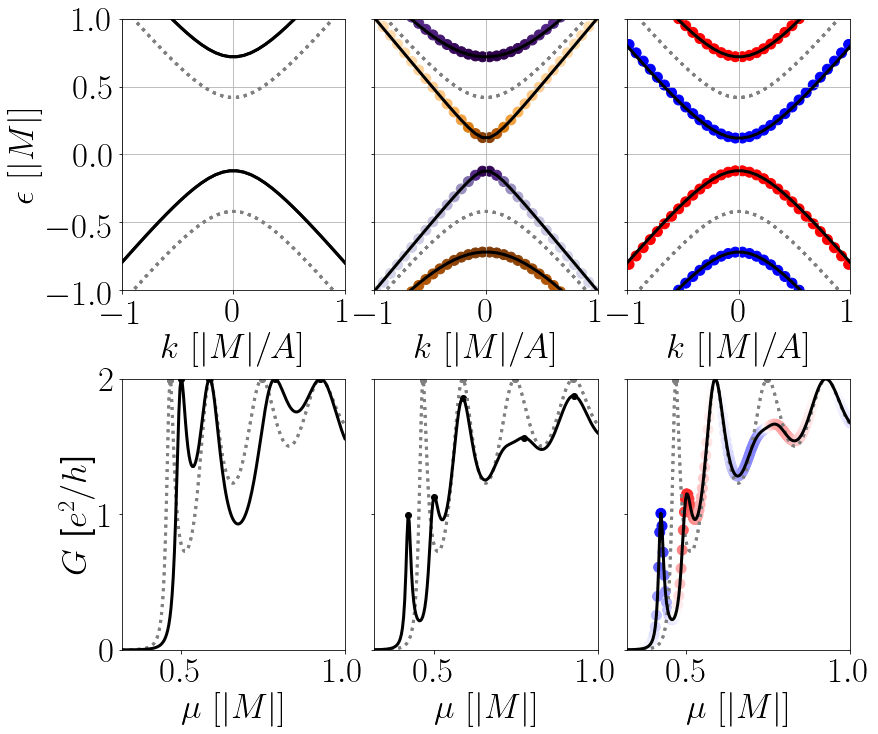

In [37]:
set_plot_conf()
fig, ax = plt.subplots(2,3, figsize=(12,10))

colorref = 'grey'
color = 'black'

font_ticks = 35
font_label = 35
font_title = 35
font_leg = 22
lw = 3.0
s = 100

set_plot_conf()
for i in range(2):
    for j in range(3):
    
        # Bands
        ax[0,j].plot(kx, en0, linewidth=lw, c=colorref, linestyle=':')
        ax[0,j].set_xlabel(R"$k$ $[|M|/A]$", fontsize = font_label)
        ax[0,j].set_ylim(-1,1)
        ax[0,j].set_yticks(np.arange(-1,1.5, 0.5))
        ax[0,j].set_xlim(-1,1)
        
        
        # Conductance
        ax[1,j].plot(en, G0, label='no bar',  c=colorref, lw=lw, ls=':')
        ax[1,j].scatter(en[peaks0], G0[peaks0], c=colorref)
        ax[1,j].set_ylim(0,2)
        ax[1,j].set_xlabel(R"$\mu$ $[|M|]$", fontsize = font_label)
        ax[1,j].set_xlim(mcons-0.1, 1)
        ax[1,j].set_yticks([0,1,2])
        
        # general settings
        ax[i,j].tick_params(axis="both", labelsize = font_ticks)
        

# Bands
        
# 0
ax[0,0].plot(kx, ens, c='black', linewidth=lw)
ax[0,0].set_ylabel(R"$\epsilon$ $[|M|]$", fontsize = font_label)
ax[0,0].grid()
# x
ax[0,1].scatter(newkx, ex, c=Sx.reshape(kpts, 4), cmap='PuOr', vmin=-1, vmax=+1, s=s)
ax[0,1].plot(kx, enx, c='black', linewidth=lw)
plt.setp(ax[0,1].get_yticklabels(), visible=False)
ax[0,1].grid()

# z ##
ax[0,2].scatter(newkx, ez, c=Sz.reshape(kpts, 4), cmap='bwr', vmin=-1, vmax=+1, s=s)
ax[0,2].plot(kx, enz, c='black', linewidth=lw)
plt.setp(ax[0,2].get_yticklabels(), visible=False)
ax[0,2].grid()
ax[0,2] = plt.gca()
# Conductance

## nu=s
ax[1,0].set_ylabel(R"$G$ [$e^2/h$]", fontsize = font_label)    
ax[1,0].plot(en, GS, label=R'$\nu=0$', c=color, lw=lw)
ax[1,0].scatter(en[peaksS], GS[peaksS], c=color)
## nu=x
ax[1,1].plot(en, GX, label=R'$\nu=x$', c=color, lw=lw)
ax[1,1].scatter(en[peaksX], GX[peaksX], c=color)
plt.setp(ax[1,1].get_yticklabels(), visible=False)
## nu=z
ax[1,2].plot(en, GZ, label='1Z', c=color, lw=lw)
ax[1,2].scatter(en[peaksZ], GZ[peaksZ],c=color)
ax[1,2].scatter(en, GZ, c=PZz.real, cmap='bwr', vmin=-1, vmax=+1, s=s)
plt.setp(ax[1,2].get_yticklabels(), visible=False)
# ax[1,2] = plt.gca()
# MAP = ax[1,2].get_children()[3]
# plt.colorbar(MAP, ax=ax[1,2])


plt.tight_layout(pad=0)
# plt.savefig("BandsandG.svg")
# plt.savefig("BandsandG.png")

# Two barriers

In [38]:
# To remember the previous parameters that were considered
# The Temperature T was previously defined for computing G with T in 1-D case

print('Barrier width =', Wb,', Lc=', Lc,)
print('T =',T)

Barrier width = 1 , Lc= 15
T = [0.01, 0.03, 0.05]


In [39]:
# An auxiliary function to compute the conductance for 2D case considering the temperature

def Gmu2D(T, mu, syst, params,  n=5, epts=len(en)):

    kT = T
    en = np.linspace(mu-n*kT, mu+n*kT, epts)
    de = en[1]-en[0]
    
    dfde = lambda en,mu: -(1/kT)*(np.exp((en-mu)/(kT))/(1+np.exp((en-mu)/(kT)))**2) 
    
    Guu = np.array([])
    Gud = np.array([])
    Gdu = np.array([])
    Gdd = np.array([])

    for energy in en:

        smatrix = kwant.smatrix(syst, energy, params=params)
        Guu = np.append(Guu, smatrix.transmission((0, 0), (1, 0)))
        Gud = np.append(Gud, smatrix.transmission((0, 0), (1, 1)))
        Gdu = np.append(Gdu, smatrix.transmission((0, 1), (1, 0)))
        Gdd = np.append(Gdd, smatrix.transmission((0, 1), (1, 1)))
        
    Guu_aux = np.sum(-Guu*dfde(en, mu)*de)
    Gud_aux = np.sum(-Gud*dfde(en, mu)*de)
    Gdu_aux = np.sum(-Gdu*dfde(en, mu)*de)
    Gdd_aux = np.sum(-Gdd*dfde(en, mu)*de)
    
#     Guu_aux = integrate.simps(-Guu*dfde(en, mu), x=en)
#     Gud_aux = integrate.simps(-Gud*dfde(en, mu), x=en)
#     Gdu_aux = integrate.simps(-Gdu*dfde(en, mu), x=en)
#     Gdd_aux = integrate.simps(-Gdd*dfde(en, mu), x=en)
    
    return np.array([Guu_aux, Gud_aux, Gdu_aux, Gdd_aux])
        

def G2D_withT(syst, params, T, mumin=mcons-0.1, mumax=1, mupts=len(en)):
    
    Guut = []
    Gudt = []
    Gdut = []
    Gddt = []
    
    mu_range = np.linspace(mumin, mumax, mupts)
    
    Gaux = np.array([Gmu2D(T, mu, syst, params) for mu in tqdm(mu_range)])
    
    Guut = Gaux[:,0]
    Gudt = Gaux[:,1]
    Gdut = Gaux[:,2]
    Gddt = Gaux[:,3]
    
# Alternative approach    
# 1st 
#     for mu in tqdm(mu_range):
#         Guut_aux, Gudt_aux, Gdut_aux, Gddt_aux = Gmu2D(T, mu, syst, params)        
        
#         Guut = np.append(Guut, Guut_aux)
#         Gudt = np.append(Gudt, Gudt_aux)
#         Gdut = np.append(Gdut, Gdut_aux)
#         Gddt = np.append(Gddt, Gddt_aux)
            
    return np.array(Guut), np.array(Gudt), np.array(Gdut), np.array(Gddt), mu_range

In [40]:
#The variables below were defined before

# en = np.linspace(mcons-0.1, 1, 300)
vi = 0.20 # common intensity

# two bar: vs
paramsSSP = dict(default2D, Nb=2, vs=vi, PAP=1)
GSSPuu, GSSPud, GSSPdu, GSSPdd, PSSP0, PSSPx, PSSPy, PSSPz = transmission(sys, en, paramsSSP, polarizations=True)
paramsSSAP = dict(default2D, Nb=2, vs=vi, PAP=-1)
GSSAPuu, GSSAPud, GSSAPdu, GSSAPdd, PSSAP0, PSSAPx, PSSAPy, PSSAPz = transmission(sys, en, paramsSSAP, polarizations=True)

# two bar: vx
paramsXXP = dict(default2D, Nb=2, vx=vi, PAP=1)
GXXPuu, GXXPud, GXXPdu, GXXPdd, PXXP0, PXXPx, PXXPy, PXXPz = transmission(sys, en, paramsXXP, polarizations=True)
paramsXXAP = dict(default2D, Nb=2, vx=vi, PAP=-1)
GXXAPuu, GXXAPud, GXXAPdu, GXXAPdd, PXXAP0, PXXAPx, PXXAPy, PXXAPz = transmission(sys, en, paramsXXAP, polarizations=True)

# two bar: vz
paramsZZP = dict(default2D, Nb=2, vz=vi, PAP=1)
GZZPuu, GZZPud, GZZPdu, GZZPdd, PZZP0, PZZPx, PZZPy, PZZPz = transmission(sys, en, paramsZZP, polarizations=True)
paramsZZAP = dict(default2D, Nb=2, vz=vi, PAP=-1)
GZZAPuu, GZZAPud, GZZAPdu, GZZAPdd, PZZAP0, PZZAPx, PZZAPy, PZZAPz = transmission(sys, en, paramsZZAP, polarizations=True)

100%|██████████| 200/200 [01:01<00:00,  3.27it/s]


In [41]:
# total G
GSSP = GSSPuu + GSSPud + GSSPdu + GSSPdd
GXXP = GXXPuu + GXXPud + GXXPdu + GXXPdd
GZZP = GZZPuu + GZZPud + GZZPdu + GZZPdd
GSSAP = GSSAPuu + GSSAPud + GSSAPdu + GSSAPdd
GXXAP = GXXAPuu + GXXAPud + GXXAPdu + GXXAPdd
GZZAP = GZZAPuu + GZZAPud + GZZAPdu + GZZAPdd

# capture peaks postions
peaksSSP = find_peaks(GSSP)[0]
peaksXXP = find_peaks(GXXP)[0]
peaksZZP = find_peaks(GZZP)[0]
peaksSSAP = find_peaks(GSSAP)[0]
peaksXXAP = find_peaks(GXXAP)[0]
peaksZZAP = find_peaks(GZZAP)[0]

## With Temperature

In [ ]:
# Conductance for 2D case (with barriers) with temperature

# P 
# S
GSPuuT1, GSPudT1, GSPduT1, GSPddT1, mu = G2D_withT(sys, paramsSSP, T[0])
GSPtotT1 = GSPuuT1 + GSPudT1 + GSPduT1 + GSPddT1
GSPuuT2, GSPudT2, GSPduT2, GSPddT2, mu = G2D_withT(sys, paramsSSP, T[1])
GSPtotT2 = GSPuuT2 + GSPudT2 + GSPduT2 + GSPddT2
GSPuuT3, GSPudT3, GSPduT3, GSPddT3, mu = G2D_withT(sys, paramsSSP, T[2])
GSPtotT3 = GSPuuT3 + GSPudT3 + GSPduT3 + GSPddT3

# x
GXPuuT1, GXPudT1, GXPduT1, GXPddT1, mu = G2D_withT(sys, paramsXXP, T[0])
GXPtotT1 = GXPuuT1 + GXPudT1 + GXPduT1 + GXPddT1
GXPuuT2, GXPudT2, GXPduT2, GXPddT2, mu = G2D_withT(sys, paramsXXP, T[1])
GXPtotT2 = GXPuuT2 + GXPudT2 + GXPduT2 + GXPddT2
GXPuuT3, GXPudT3, GXPduT3, GXPddT3, mu = G2D_withT(sys, paramsXXP, T[2])
GXPtotT3 = GXPuuT3 + GXPudT3 + GXPduT3 + GXPddT3
# z
GZPuuT1, GZPudT1, GZPduT1, GZPddT1, mu = G2D_withT(sys, paramsZZP, T[0])
GZPtotT1 = GZPuuT1 + GZPudT1 + GZPduT1 + GZPddT1
GZPuuT2, GZPudT2, GZPduT2, GZPddT2, mu = G2D_withT(sys, paramsZZP, T[1])
GZPtotT2 = GZPuuT2 + GZPudT2 + GZPduT2 + GZPddT2
GZPuuT3, GZPudT3, GZPduT3, GZPddT3, mu = G2D_withT(sys, paramsZZP, T[2])
GZPtotT3 = GZPuuT3 + GZPudT3 + GZPduT3 + GZPddT3

# AP 
# S
GSAPuuT1, GSAPudT1, GSAPduT1, GSAPddT1, mu = G2D_withT(sys, paramsSSAP, T[0])
GSAPtotT1 = GSAPuuT1 + GSAPudT1 + GSAPduT1 + GSAPddT1
GSAPuuT2, GSAPudT2, GSAPduT2, GSAPddT2, mu = G2D_withT(sys, paramsSSAP, T[1])
GSAPtotT2 = GSAPuuT2 + GSAPudT2 + GSAPduT2 + GSAPddT2
GSAPuuT3, GSAPudT3, GSAPduT3, GSAPddT3, mu = G2D_withT(sys, paramsSSAP, T[2])
GSAPtotT3 = GSAPuuT3 + GSAPudT3 + GSAPduT3 + GSAPddT3
# x
GXAPuuT1, GXAPudT1, GXAPduT1, GXAPddT1, mu = G2D_withT(sys, paramsXXAP, T[0])
GXAPtotT1 = GXAPuuT1 + GXAPudT1 + GXAPduT1 + GXAPddT1
GXAPuuT2, GXAPudT2, GXAPduT2, GXAPddT2, mu = G2D_withT(sys, paramsXXAP, T[1])
GXAPtotT2 = GXAPuuT2 + GXAPudT2 + GXAPduT2 + GXAPddT2
GXAPuuT3, GXAPudT3, GXAPduT3, GXAPddT3, mu = G2D_withT(sys, paramsXXAP, T[2])
GXAPtotT3 = GXAPuuT3 + GXAPudT3 + GXAPduT3 + GXAPddT3
# z
GZAPuuT1, GZAPudT1, GZAPduT1, GZAPddT1, mu = G2D_withT(sys, paramsZZAP, T[0])
GZAPtotT1 = GZAPuuT1 + GZAPudT1 + GZAPduT1 + GZAPddT1
GZAPuuT2, GZAPudT2, GZAPduT2, GZAPddT2, mu = G2D_withT(sys, paramsZZAP, T[1])
GZAPtotT2 = GZAPuuT2 + GZAPudT2 + GZAPduT2 + GZAPddT2
GZAPuuT3, GZAPudT3, GZAPduT3, GZAPddT3, mu = G2D_withT(sys, paramsZZAP, T[2])
GZAPtotT3 = GZAPuuT3 + GZAPudT3 + GZAPduT3 + GZAPddT3

## GMR

In [ ]:
# s
GMRs = (GSSP-GSSAP)/(GSSP+GSSAP)
GMRS_T1 = (GSPtotT1-GSAPtotT1)/(GSPtotT1+GSAPtotT1)
GMRS_T2 = (GSPtotT2-GSAPtotT2)/(GSPtotT2+GSAPtotT2)
GMRS_T3 = (GSPtotT3-GSAPtotT3)/(GSPtotT3+GSAPtotT3)


# x
GMRx = (GXXP-GXXAP)/(GXXP+GXXAP)
GMRx_T1 = (GXPtotT1-GXAPtotT1)/(GXPtotT1+GXAPtotT1)
GMRx_T2 = (GXPtotT2-GXAPtotT2)/(GXPtotT2+GXAPtotT2)
GMRx_T3 = (GXPtotT3-GXAPtotT3)/(GXPtotT3+GXAPtotT3)


# z
GMRz = (GZZP-GZZAP)/(GZZP+GZZAP)
GMRz_T1 = (GZPtotT1-GZAPtotT1)/(GZPtotT1+GZAPtotT1)
GMRz_T2 = (GZPtotT2-GZAPtotT2)/(GZPtotT2+GZAPtotT2)
GMRz_T3 = (GZPtotT3-GZAPtotT3)/(GZPtotT3+GZAPtotT3)

In [42]:
# no bars
params0 = dict(default2D)
G0uu, G0ud, G0du, G0dd, P00, P0x, P0y, P0z = transmission(sys, en, params0, polarizations=True)

G0 = G0uu + G0ud + G0du + G0dd

100%|██████████| 200/200 [01:01<00:00,  3.28it/s]


In [53]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(8,9))

lw = 4
font_ticks = 30
font_label = 30
font_leg = 15
font_text = 30

# set_plot_conf()
for i in range(2):
    for j in range(2):

        # General settings
        ax[i,j].tick_params(axis="both", labelsize=font_ticks)
        
        # Conductance
        ax[0,j].plot(en, G0, c='darkslategrey', ls=':', lw=lw)
        ax[0,0].set_ylabel(R"$G$ $[e^2/h]$", fontsize=font_label)
        ax[0,j].set_ylim(0,2)
        ax[0,j].set_yticks([0,1,2])

        # GMR
        ax[1,0].set_ylabel(R"$\delta G$", fontsize=font_label)
        ax[1,j].set_xlabel(R"$\mu$ $[|M|]$ ", fontsize=font_label);
        ax[1,j].set_xlim(round(mcons-0.1,1),0.8)
        ax[1,j].set_xticks(np.arange(round(mcons-0.1,1) ,0.8,0.2))
        ax[1,j].set_ylim(0,1)
        ax[1,j].set_yticks(np.arange(0,1.5,0.5))
        
#P-X / AP-X
ax[0,0].text(x=0.31, y=1.8, s=R'$(a)$', fontsize=font_text)
ax[0,0].plot(en, GXXP,  c='black', lw=lw, label="P")
ax[0,0].plot(en, GXXAP, c='green', alpha=0.5,lw=lw, label="AP")
ax[0,0].legend(loc='lower right', fontsize=font_leg)

#P-Z / AP-Z
ax[0,1].text(x=0.31, y=1.8, s=R'$(b)$', fontsize=font_text)
ax[0,1].plot(en, GZZP,  c='black', label="P")
ax[0,1].scatter(en, GZZP, c=PZZPz.real, cmap='bwr', vmin=-1, vmax=+1, s=40)
ax[0,1].plot(en, GZZAP, c='green', alpha=0.5, lw=lw, label="AP")
ax[0,1].legend(loc='lower right', fontsize=font_leg)
plt.setp(ax[0,1].get_yticklabels(), visible=False)

ax[1,0].text(x=0.31, y=0.9, s=R'$(c)$', fontsize=font_text)
ax[1,0].plot(en, np.abs(GMRx), label=R'$k_{B}T=0$', ls=':', c='darkslategrey', lw=lw)
ax[1,0].plot(mu,  np.abs(GMRx_T1), label=R"$k_{B}T$="+str(T[0]), ls='-' ,c='mediumblue', lw=lw);
ax[1,0].plot(mu,  np.abs(GMRx_T2), label=R"$k_{B}T$="+str(T[1]), ls='-' ,c='darkorange', lw=lw);
ax[1,0].plot(mu,  np.abs(GMRx_T3), label=R"$k_{B}T$="+str(T[2]), ls='-' ,c='black', lw=lw);
ax[1,0].legend(loc='upper right', fontsize=font_leg)

ax[1,1].text(x=0.31, y=0.9, s=R'$(d)$', fontsize=font_text)
ax[1,1].plot(en, np.abs(GMRz), label=R'$k_{B}T=0$', ls=':', c='darkslategrey', lw=lw)
ax[1,1].plot(mu,  np.abs(GMRz_T1), label=R"$k_{B}T$="+str(T[0]), ls='-' ,c='mediumblue', lw=lw);
ax[1,1].plot(mu,  np.abs(GMRz_T2), label=R"$k_{B}T$="+str(T[1]), ls='-' ,c='darkorange', lw=lw);
ax[1,1].plot(mu,  np.abs(GMRz_T3), label=R"$k_{B}T$="+str(T[2]), ls='-' ,c='black', lw=lw);
ax[1,1].legend(loc='upper right', fontsize=font_leg)
plt.setp(ax[1,1].get_yticklabels(), visible=False)

plt.tight_layout(pad=0.1)
# plt.savefig("GMR.svg")

## Current densities: 2 bars S

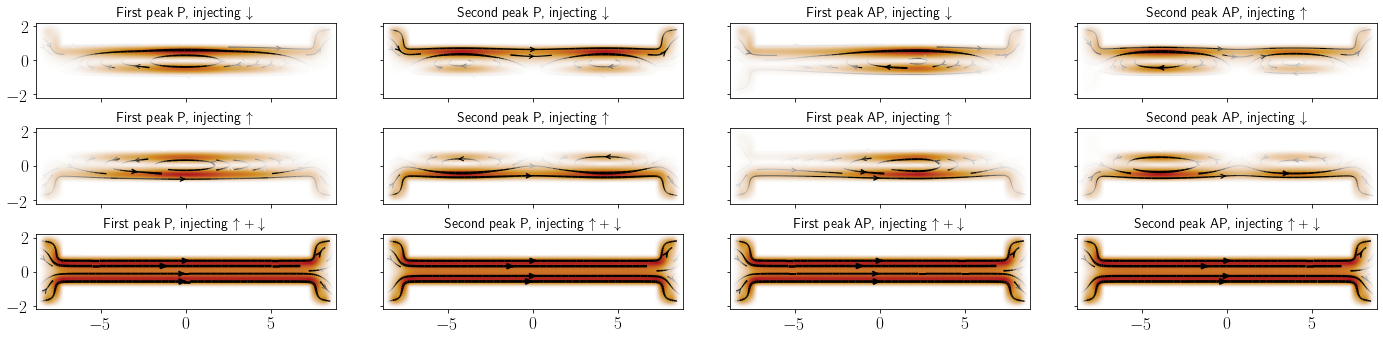

In [44]:
psi0 = kwant.wave_function(sys, energy=en[peaksSSP[0]], params=paramsSSP)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksSSP[1]], params=paramsSSP)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksSSAP[0]], params=paramsSSAP)(0)
psi3 = kwant.wave_function(sys, energy=en[peaksSSAP[1]], params=paramsSSAP)(0)

# choose which current density to run: 
#  J0  : charge
#  JZ  : sigma_z projection = up - dw
#  JX  : sigma_x projection = (+x) - (-x)
#  Jup : spin up component
#  Jdw : spin dw component
#  JXP : spin (+x) component
#  JXM : spin (-x) component
Jop = J0

fig, ax = plt.subplots(3,4, sharex=True, sharey=True, figsize=(20,5))

current = Jop(psi0[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0])
ax[0,0].set_title(R"First peak P, injecting $\downarrow$", fontsize=14)

current = Jop(psi0[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0])
ax[1,0].set_title(R"First peak P, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi0)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0])
ax[2,0].set_title(R"First peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi1[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1])
ax[0,1].set_title(R"Second peak P, injecting $\downarrow$", fontsize=14)

current = Jop(psi1[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1])
ax[1,1].set_title(R"Second peak P, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi1)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1])
ax[2,1].set_title(R"Second peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi2[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,2])
ax[0,2].set_title(R"First peak AP, injecting $\downarrow$", fontsize=14)

current = Jop(psi2[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,2])
ax[1,2].set_title(R"First peak AP, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi2)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,2])
ax[2,2].set_title(R"First peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi3[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,3])
ax[0,3].set_title(R"Second peak AP, injecting $\uparrow$", fontsize=14)

current = Jop(psi3[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,3])
ax[1,3].set_title(R"Second peak AP, injecting $\downarrow$", fontsize=14)

current = sum(Jop(p) for p in psi3)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,3])
ax[2,3].set_title(R"Second peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

## Density: 2 bars S

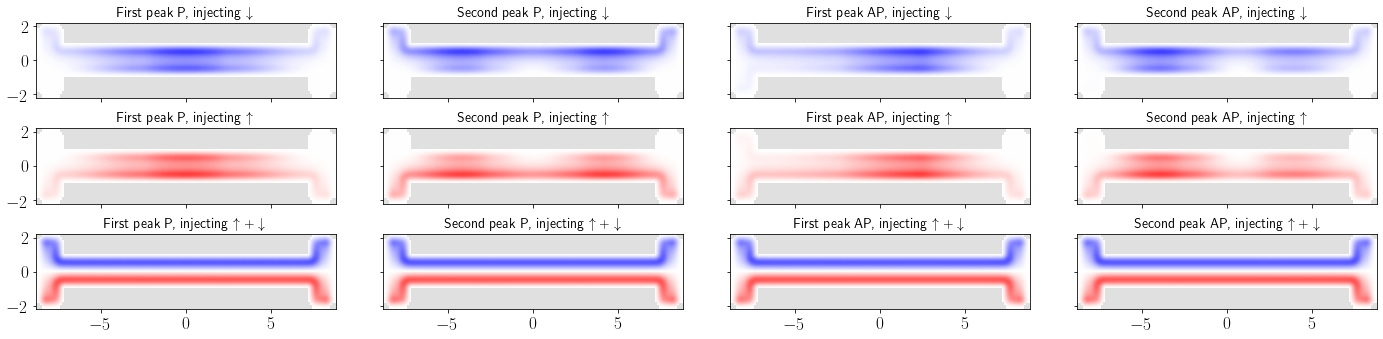

In [45]:
psi0 = kwant.wave_function(sys, energy=en[peaksSSP[0]], params=paramsSSP)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksSSP[1]], params=paramsSSP)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksSSAP[0]], params=paramsSSAP)(0)
psi3 = kwant.wave_function(sys, energy=en[peaksSSAP[1]], params=paramsSSAP)(0)

# choose which density to run: 
#  D0  : charge
#  DZ  : sigma_z projection = up - dw
#  DX  : sigma_x projection = (+x) - (-x)
#  Dup : spin up component
#  Ddw : spin dw component
#  DXP : spin (+x) component
#  DXM : spin (-x) component
Dop = DZ
fsat = 10 # saturation factor for color scale
cmap = 'bwr'

fig, ax = plt.subplots(3,4, sharex=True, sharey=True, figsize=(20,5))

density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,0])
ax[0,0].set_title(R"First peak P, injecting $\downarrow$", fontsize=14)

density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,0])
ax[1,0].set_title(R"First peak P, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,0])
ax[2,0].set_title(R"First peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,1])
ax[0,1].set_title(R"Second peak P, injecting $\downarrow$", fontsize=14)

density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,1])
ax[1,1].set_title(R"Second peak P, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,1])
ax[2,1].set_title(R"Second peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi2[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,2])
ax[0,2].set_title(R"First peak AP, injecting $\downarrow$", fontsize=14)

density = Dop(psi2[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,2])
ax[1,2].set_title(R"First peak AP, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi2); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,2])
ax[2,2].set_title(R"First peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi3[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,3])
ax[0,3].set_title(R"Second peak AP, injecting $\downarrow$", fontsize=14)

density = Dop(psi3[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,3])
ax[1,3].set_title(R"Second peak AP, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi3); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,3])
ax[2,3].set_title(R"Second peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

## Current densities: 2 bars X

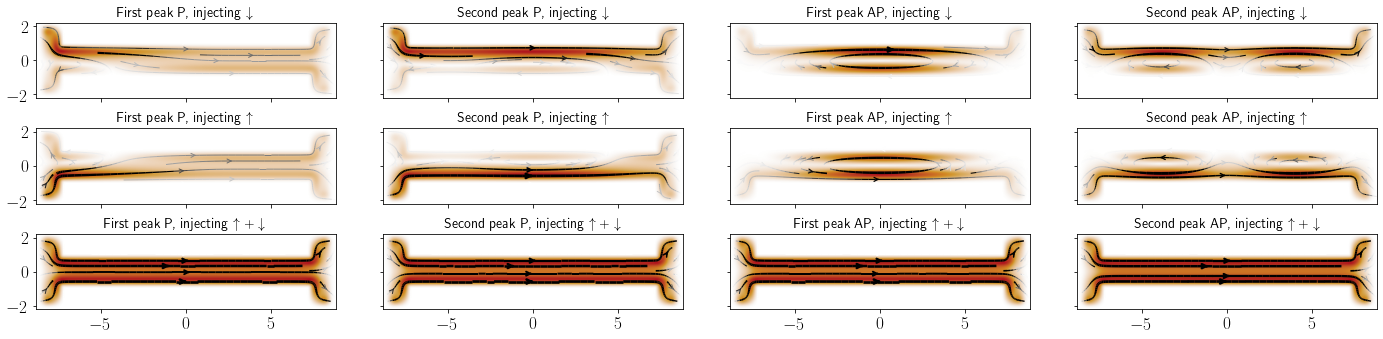

In [46]:
psi0 = kwant.wave_function(sys, energy=en[peaksXXP[0]], params=paramsXXP)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksXXP[1]], params=paramsXXP)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksXXAP[0]], params=paramsXXAP)(0)
psi3 = kwant.wave_function(sys, energy=en[peaksXXAP[1]], params=paramsXXAP)(0)

# choose which current density to run: 
#  J0  : charge
#  JZ  : sigma_z projection = up - dw
#  JX  : sigma_x projection = (+x) - (-x)
#  Jup : spin up component
#  Jdw : spin dw component
#  JXP : spin (+x) component
#  JXM : spin (-x) component
Jop = J0

fig, ax = plt.subplots(3,4, sharex=True, sharey=True, figsize=(20,5))

current = Jop(psi0[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0])
ax[0,0].set_title(R"First peak P, injecting $\downarrow$", fontsize=14)

current = Jop(psi0[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0])
ax[1,0].set_title(R"First peak P, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi0)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0])
ax[2,0].set_title(R"First peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi1[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1])
ax[0,1].set_title(R"Second peak P, injecting $\downarrow$", fontsize=14)

current = Jop(psi1[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1])
ax[1,1].set_title(R"Second peak P, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi1)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1])
ax[2,1].set_title(R"Second peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi2[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,2])
ax[0,2].set_title(R"First peak AP, injecting $\downarrow$", fontsize=14)

current = Jop(psi2[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,2])
ax[1,2].set_title(R"First peak AP, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi2)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,2])
ax[2,2].set_title(R"First peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi3[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,3])
ax[0,3].set_title(R"Second peak AP, injecting $\downarrow$", fontsize=14)

current = Jop(psi3[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,3])
ax[1,3].set_title(R"Second peak AP, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi3)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,3])
ax[2,3].set_title(R"Second peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

## Densities: 2 bars X

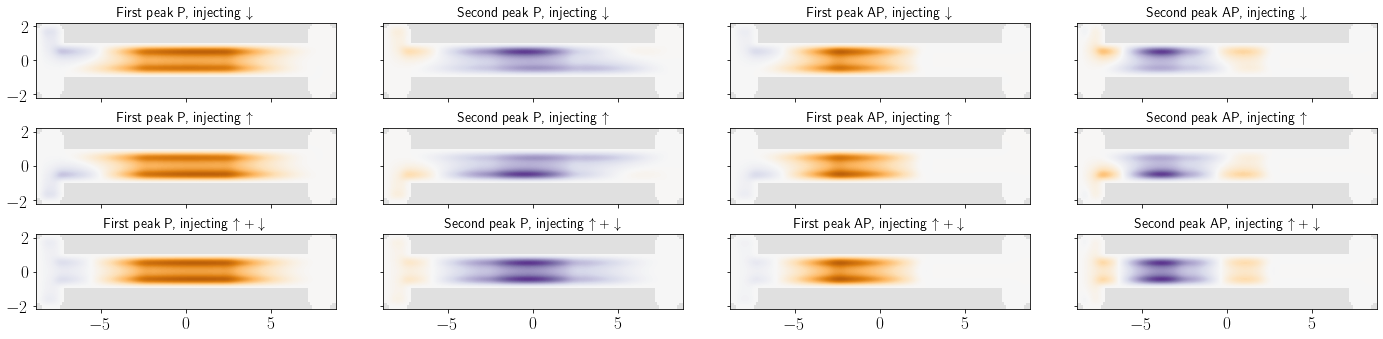

In [47]:
psi0 = kwant.wave_function(sys, energy=en[peaksXXP[0]], params=paramsXXP)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksXXP[1]], params=paramsXXP)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksXXAP[0]], params=paramsXXAP)(0)
psi3 = kwant.wave_function(sys, energy=en[peaksXXAP[1]], params=paramsXXAP)(0)

# choose which density to run: 
#  D0  : charge
#  DZ  : sigma_z projection = up - dw
#  DX  : sigma_x projection = (+x) - (-x)
#  Dup : spin up component
#  Ddw : spin dw component
#  DXP : spin (+x) component
#  DXM : spin (-x) component
Dop = DX
fsat = 10 # saturation factor for color scale
cmap = 'PuOr'

fig, ax = plt.subplots(3,4, sharex=True, sharey=True, figsize=(20,5))

density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,0])
ax[0,0].set_title(R"First peak P, injecting $\downarrow$", fontsize=14)

density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,0])
ax[1,0].set_title(R"First peak P, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,0])
ax[2,0].set_title(R"First peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,1])
ax[0,1].set_title(R"Second peak P, injecting $\downarrow$", fontsize=14)

density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,1])
ax[1,1].set_title(R"Second peak P, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,1])
ax[2,1].set_title(R"Second peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi2[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,2])
ax[0,2].set_title(R"First peak AP, injecting $\downarrow$", fontsize=14)

density = Dop(psi2[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,2])
ax[1,2].set_title(R"First peak AP, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi2); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,2])
ax[2,2].set_title(R"First peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi3[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,3])
ax[0,3].set_title(R"Second peak AP, injecting $\downarrow$", fontsize=14)

density = Dop(psi3[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,3])
ax[1,3].set_title(R"Second peak AP, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi3); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,3])
ax[2,3].set_title(R"Second peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

## Current + Density: 2 Barries X

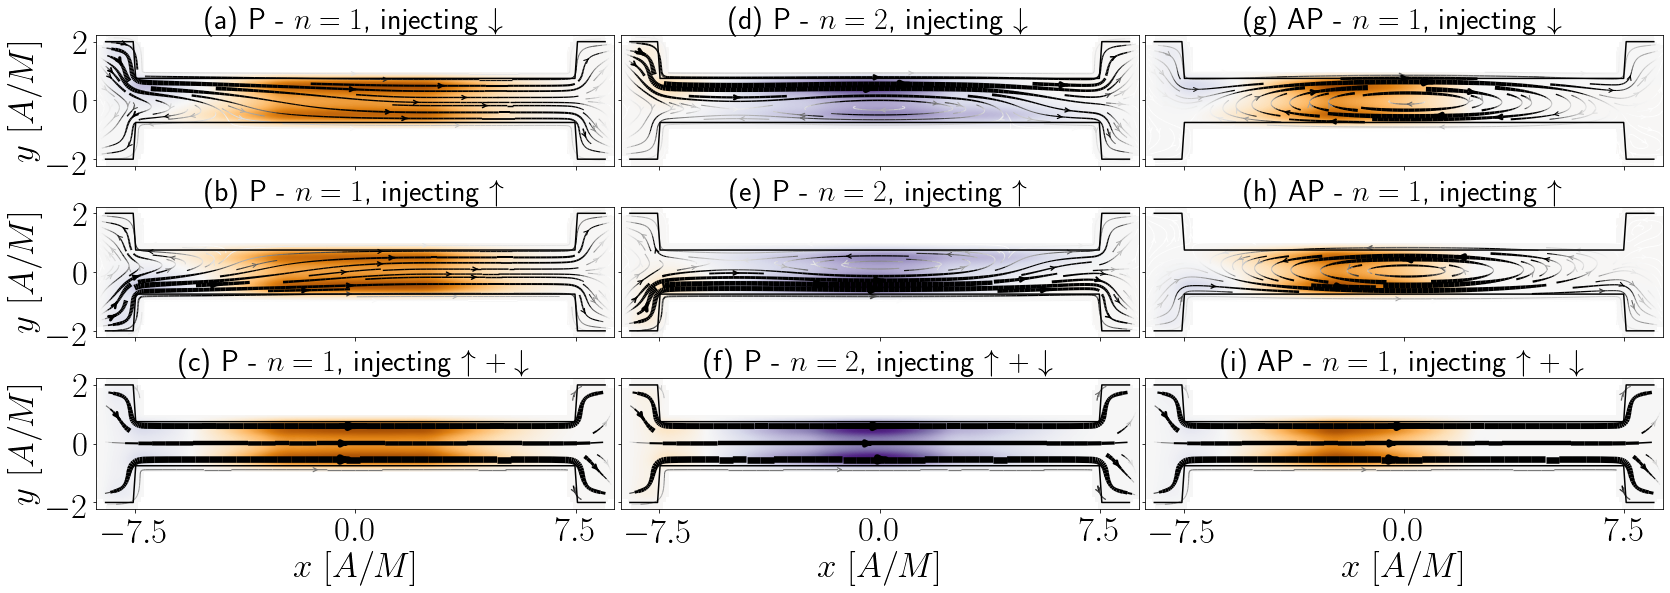

In [48]:
def const_shape(x, Lc, Wc, Wl):
    if np.abs(x) < Lc/2:
        return(Wc/2)
    else:
        return(Wl/2)
    
x = np.linspace(-Lx/2, Lx/2, 200)
y = np.array([const_shape(xi, Lc, Wc, Wl) for xi in x])

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(23,8))

font_ticks = 35
font_label = 35
font_title = 30
font_leg = 12

arrow_density = 0.5 #0.2 defaut
max_lw = 6 # 3=default

Jop = J0
Dop = DX
fsat = 9
cmap = 'PuOr'

# set_plot_conf()
for i in range(3):
    for j in range(3):
        ax[i,j].plot(x, +y, c='black')
        ax[i,j].plot(x, -y, c='black')
        
        ax[i,j].tick_params(axis="both", labelsize=font_ticks)
        ax[i,0].set_ylabel(R"$y$ $[A/M]$", fontsize=font_label)
        ax[2,j].set_xlabel(R"$x$ $[A/M]$", fontsize=font_label)
        ax[2,j].set_xticks([-Lc/2,0,Lc/2])


current = Jop(psi0[0])
density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,0].set_title(R"(a) P - $n=1$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi0[1])
density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,0].set_title(R"(b) P - $n=1$, injecting $\uparrow$", fontsize=font_title)

current = sum(Jop(p) for p in psi0)
density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,0].set_title(R"(c) P - $n=1$, injecting $\uparrow + \downarrow$", fontsize=font_title)

# #
current = Jop(psi1[0])
density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,1].set_title(R"(d) P - $n=2$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi1[1])
density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,1].set_title(R"(e) P - $n=2$, injecting $\uparrow$", fontsize=font_title)

current = sum(Jop(p) for p in psi1)
density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,1].set_title(R"(f) P - $n=2$, injecting $\uparrow + \downarrow$", fontsize=font_title)

current = Jop(psi2[0])
density = Dop(psi2[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,2])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,2], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,2].set_title(R"(g) AP - $n=1$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi2[1])
density = Dop(psi2[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,2])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,2], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,2].set_title(R"(h) AP - $n=1$, injecting $\uparrow$", fontsize=font_title)

current = sum(Jop(p) for p in psi2)
density = sum(Dop(p) for p in psi2); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,2])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,2], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,2].set_title(R"(i) AP - $n=1$, injecting $\uparrow + \downarrow$", fontsize=font_title)

plt.tight_layout(pad=0)
plt.show()

## Current densities: 2 bars Z

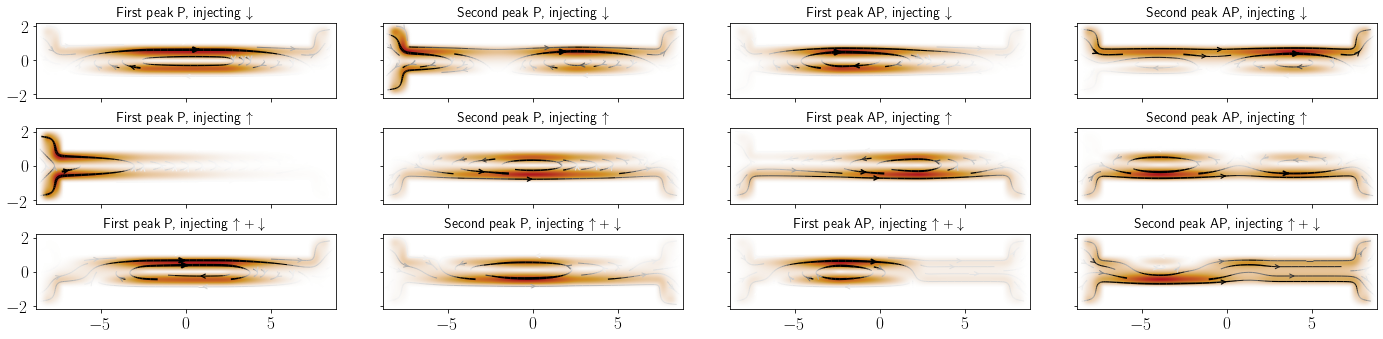

In [49]:
psi0 = kwant.wave_function(sys, energy=en[peaksZZP[0]], params=paramsZZP)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksZZP[1]], params=paramsZZP)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksZZAP[0]], params=paramsZZAP)(0)
psi3 = kwant.wave_function(sys, energy=en[peaksZZAP[1]], params=paramsZZAP)(0)

# choose which current density to run: 
#  J0  : charge
#  JZ  : sigma_z projection = up - dw
#  JX  : sigma_x projection = (+x) - (-x)
#  Jup : spin up component
#  Jdw : spin dw component
#  JXP : spin (+x) component
#  JXM : spin (-x) component
Jop = J0

fig, ax = plt.subplots(3,4, sharex=True, sharey=True, figsize=(20,5))

current = Jop(psi0[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0])
ax[0,0].set_title(R"First peak P, injecting $\downarrow$", fontsize=14)

current = Jop(psi0[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0])
ax[1,0].set_title(R"First peak P, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi0)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0])
ax[2,0].set_title(R"First peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi1[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1])
ax[0,1].set_title(R"Second peak P, injecting $\downarrow$", fontsize=14)

current = Jop(psi1[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1])
ax[1,1].set_title(R"Second peak P, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi1)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1])
ax[2,1].set_title(R"Second peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi2[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,2])
ax[0,2].set_title(R"First peak AP, injecting $\downarrow$", fontsize=14)

current = Jop(psi2[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,2])
ax[1,2].set_title(R"First peak AP, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi2)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,2])
ax[2,2].set_title(R"First peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

#

current = Jop(psi3[0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,3])
ax[0,3].set_title(R"Second peak AP, injecting $\downarrow$", fontsize=14)

current = Jop(psi3[1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,3])
ax[1,3].set_title(R"Second peak AP, injecting $\uparrow$", fontsize=14)

current = sum(Jop(p) for p in psi3)
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,3])
ax[2,3].set_title(R"Second peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

## Densities: 2 bars Z

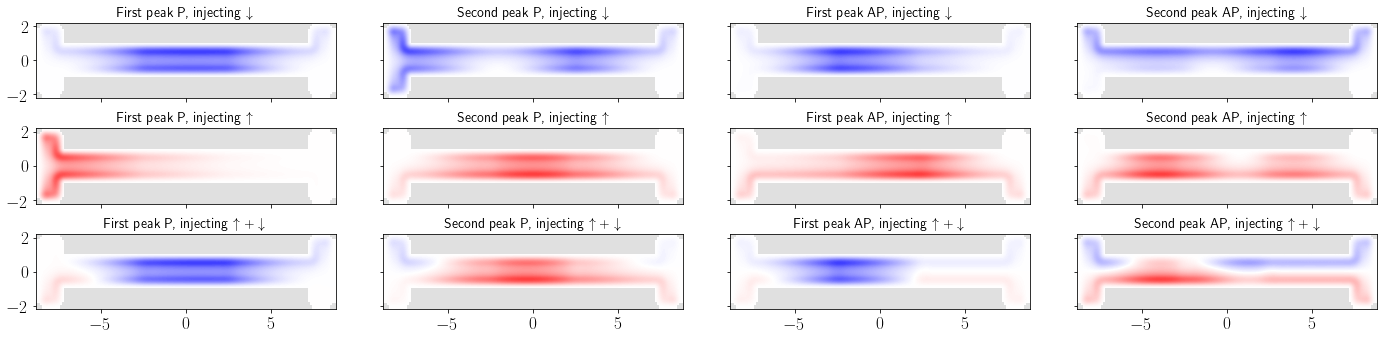

In [50]:
psi0 = kwant.wave_function(sys, energy=en[peaksZZP[0]], params=paramsZZP)(0)
psi1 = kwant.wave_function(sys, energy=en[peaksZZP[1]], params=paramsZZP)(0)
psi2 = kwant.wave_function(sys, energy=en[peaksZZAP[0]], params=paramsZZAP)(0)
psi3 = kwant.wave_function(sys, energy=en[peaksZZAP[1]], params=paramsZZAP)(0)

# choose which density to run: 
#  D0  : charge
#  DZ  : sigma_z projection = up - dw
#  DX  : sigma_x projection = (+x) - (-x)
#  Dup : spin up component
#  Ddw : spin dw component
#  DXP : spin (+x) component
#  DXM : spin (-x) component
Dop = DZ
fsat = 10 # saturation factor for color scale
cmap = 'bwr'

fig, ax = plt.subplots(3,4, sharex=True, sharey=True, figsize=(20,5))

density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,0])
ax[0,0].set_title(R"First peak P, injecting $\downarrow$", fontsize=14)

density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,0])
ax[1,0].set_title(R"First peak P, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,0])
ax[2,0].set_title(R"First peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,1])
ax[0,1].set_title(R"Second peak P, injecting $\downarrow$", fontsize=14)

density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,1])
ax[1,1].set_title(R"Second peak P, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,1])
ax[2,1].set_title(R"Second peak P, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi2[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,2])
ax[0,2].set_title(R"First peak AP, injecting $\downarrow$", fontsize=14)

density = Dop(psi2[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,2])
ax[1,2].set_title(R"First peak AP, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi2); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,2])
ax[2,2].set_title(R"First peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

#

density = Dop(psi3[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,3])
ax[0,3].set_title(R"Second peak AP, injecting $\downarrow$", fontsize=14)

density = Dop(psi3[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,3])
ax[1,3].set_title(R"Second peak AP, injecting $\uparrow$", fontsize=14)

density = sum(Dop(p) for p in psi3); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,3])
ax[2,3].set_title(R"Second peak AP, injecting $\uparrow + \downarrow$", fontsize=14)

plt.tight_layout()
plt.show()

## Current + Density: 2 bars Z

In [51]:
def const_shape(x, Lc, Wc, Wl):
    if np.abs(x) < Lc/2:
        return(Wc/2)
    else:
        return(Wl/2)
    
x = np.linspace(-Lx/2, Lx/2, 200)
y = np.array([const_shape(xi, Lc, Wc, Wl) for xi in x])

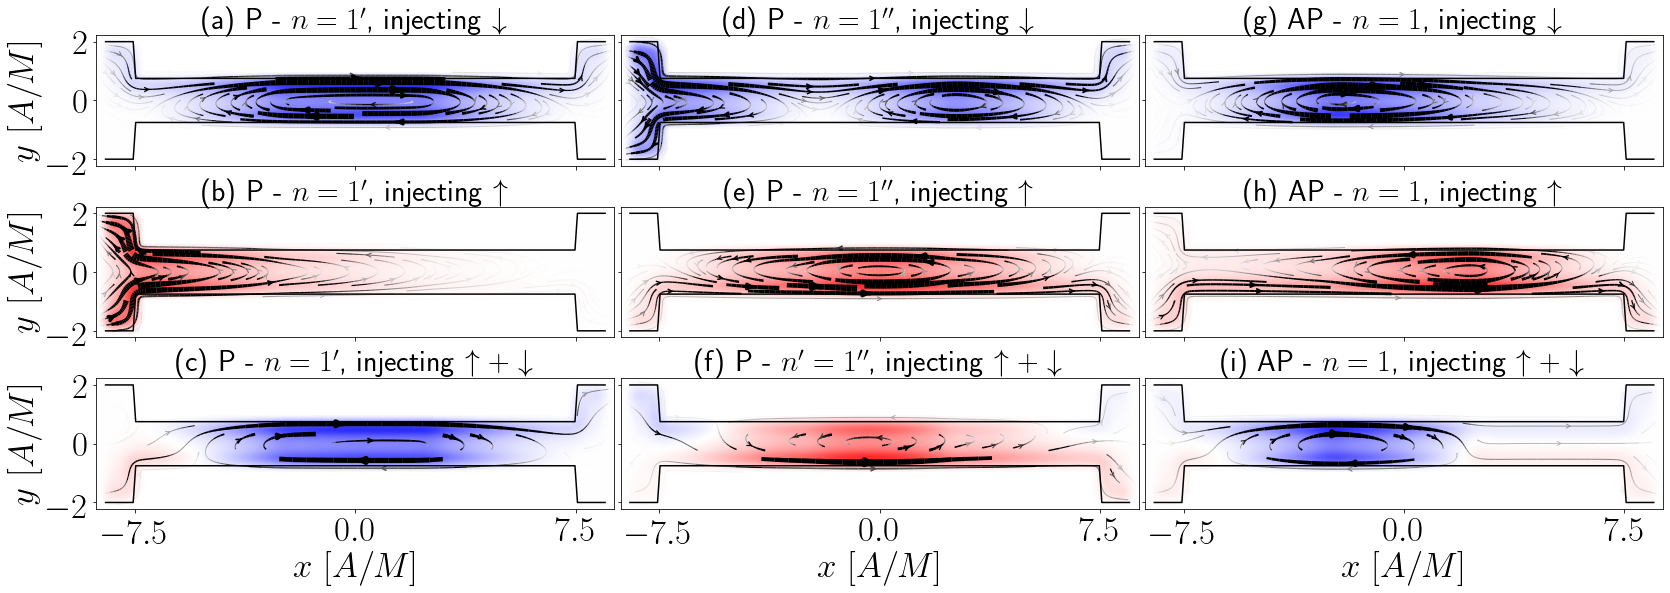

In [52]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(23,8))

font_ticks = 35
font_label = 35
font_title = 30
font_leg = 12

arrow_density = 0.5 #0.2 defaut
max_lw = 7 # 3=default

Jop = J0
Dop = DZ
fsat = 9
cmap = 'bwr'

# set_plot_conf()
for i in range(3):
    for j in range(3):
        ax[i,j].plot(x, +y, c='black')
        ax[i,j].plot(x, -y, c='black')
        
        ax[i,j].tick_params(axis="both", labelsize=font_ticks)
        ax[i,0].set_ylabel(R"$y$ $[A/M]$", fontsize=font_label)
        ax[2,j].set_xlabel(R"$x$ $[A/M]$", fontsize=font_label)
        ax[2,j].set_xticks([-Lc/2,0,Lc/2])
        
#         ax[i,j].bar(x=+2.5, height=2, width=1, alpha=0.5, color='black');
#         ax[i,j].bar(x=-2.5, height=2, width=1, alpha=0.5, color='black');


current = Jop(psi0[0])
density = Dop(psi0[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,0], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,0].set_title(R"(a) P - $n=1^{\prime}$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi0[1])
density = Dop(psi0[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,0], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,0].set_title(R"(b) P - $n=1^{\prime}$, injecting $\uparrow$", fontsize=font_title)

current = sum(Jop(p) for p in psi0)
density = sum(Dop(p) for p in psi0); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,0])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,0], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,0].set_title(R"(c) P - $n=1^{\prime}$, injecting $\uparrow + \downarrow$", fontsize=font_title)

# #
current = Jop(psi1[0])
density = Dop(psi1[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,1], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,1].set_title(R"(d) P - $n=1^{\prime\prime}$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi1[1])
density = Dop(psi1[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,1], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,1].set_title(R"(e) P - $n=1^{\prime\prime}$, injecting $\uparrow$", fontsize=font_title)

current = sum(Jop(p) for p in psi1)
density = sum(Dop(p) for p in psi1); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,1])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,1], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,1].set_title(R"(f) P - $n'=1^{\prime\prime}$, injecting $\uparrow + \downarrow$", fontsize=font_title)

current = Jop(psi2[0])
density = Dop(psi2[0]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[0,2])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[0,2], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[0,2].set_title(R"(g) AP - $n=1$, injecting $\downarrow$", fontsize=font_title)

current = Jop(psi2[1])
density = Dop(psi2[1]); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[1,2])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[1,2], bgcolor='white', max_linewidth=max_lw, density=arrow_density)
ax[1,2].set_title(R"(h) AP - $n=1$, injecting $\uparrow$", fontsize=font_title)

current = sum(Jop(p) for p in psi2)
density = sum(Dop(p) for p in psi2); vmax = fsat*np.abs(density).max()
kwant.plotter.density(sys, density, vmin=-vmax, vmax=vmax, cmap=cmap, ax=ax[2,2])
kwant.plotter.current(sys, current, colorbar=False, ax=ax[2,2], bgcolor='white', max_linewidth=7, density=0.2)
ax[2,2].set_title(R"(i) AP - $n=1$, injecting $\uparrow + \downarrow$", fontsize=font_title)

plt.tight_layout(pad=0)
# plt.savefig("2barsZZ-currentdensityZ.svg")
plt.show()